"Анализ аномалий в поголовье крупного рогатого скота"

Анализ аномалий

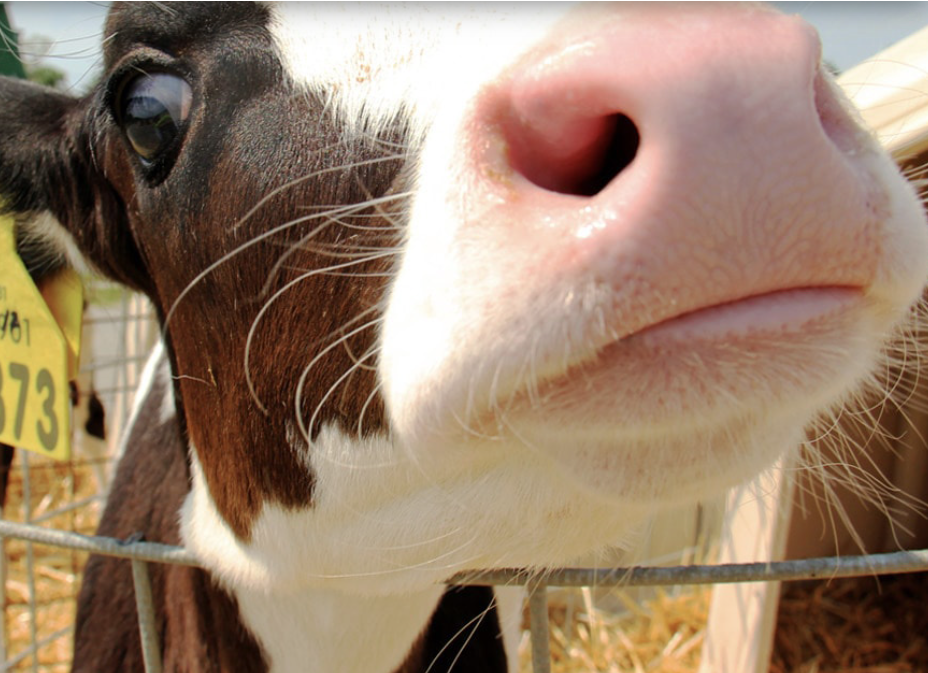

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
from datetime import datetime, timedelta

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm import tqdm

In [4]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.svm import OneClassSVM

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [6]:
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Подготовка датасета для анализа аномалий:

In [8]:
df_cow_id = pd.read_csv('data/' + 'cowid_data.csv')

In [9]:
df_cow_id.head()

CowID
0  RU3111005007477
1  RU3101100547276
2  RU3101100546247
3  RU3111005006383
4     DE0359300215

Упитанность:

In [10]:
df_fatness = pd.read_csv('data/' + 'fatness_prep.csv', sep=';', decimal=',')

In [11]:
df_fatness = df_fatness.groupby(['CowID']).agg({'Fatness': ['mean']})
df_fatness.reset_index(inplace=True)

In [12]:
df_fatness.head()

CowID   Fatness
                     mean
0  CZ0291447962  3.000000
1  CZ0294530962  3.000000
2  CZ0294598962  2.750000
3  CZ0298122972  2.916667
4  CZ0298124972  2.833333

Надой:

In [13]:
df_milking = pd.read_csv('data/' + 'milking_data.zip')

In [14]:
df_milking = df_milking.drop(df_milking[df_milking.CowID == '-'].index)

In [15]:
df_milking = df_milking.groupby(['CowID']).agg({'MilkingAmount': ['mean'], 'MilkingTime': ['mean']})

In [16]:
df_milking.reset_index(inplace=True)

In [17]:
df_milking.head()

CowID MilkingAmount MilkingTime
                         mean        mean
0  CZ0286619962     27.505851  699.792553
1  CZ0286629962     24.106886  681.643599
2  CZ0289130962     24.111459  671.255856
3  CZ0289133962     26.827136  593.428811
4  CZ0291447962     24.808152  694.121519

Заболевания:

In [18]:
df_heal = pd.read_csv('data/' + 'heal_prep.csv', sep=';')

In [19]:
df_heal = df_heal.groupby(['CowID']).agg({'CowDiagnosis': ['count'], 'HealDays': ['sum']})

In [20]:
df_heal.reset_index(inplace=True)

Хромота:

In [21]:
df_lameness = pd.read_csv('data/' + 'lameness_prep.csv', sep=';')

In [22]:
df_lameness.head()

Date            CowID LamenessSchema      Drug  LamenessDays
0  01.08.2019  RU3101090116342              -  С3.41.1Q             0
1  01.08.2019  RU3101150173791      Нет схемы  ЯЗВАР.4Q             0
2  01.08.2019  RU3101090127462      Нет схемы  ЯЗВАР.3Q             0
3  01.08.2019  RU3101090127719      Нет схемы  С3.42.3Q             0
4  03.08.2019  RU3110204012988      Нет схемы  СХ3.5.3Q             0

In [23]:
df_lameness = df_lameness.groupby(['CowID']).agg({'LamenessSchema': ['count'], 'LamenessDays': ['sum']})

In [24]:
df_lameness.reset_index(inplace=True)

Смещение сычуга:

In [25]:
df_maw = pd.read_csv('data/' + 'maw_prep.csv', sep=';')

In [26]:
df_maw.head()

Date            CowID  MawSchema Operation  MawDays
0  04.10.2019  RU3111005007152  Нет схемы  ОПЕРАЦИЯ        0
1  19.10.2019  RU3101090128018  Нет схемы  ОПЕРАЦИЯ        0
2  20.10.2019  RU3101090128018  Нет схемы  ОПЕРАЦИЯ        0
3  06.11.2019     NL0750519814  Нет схемы  ОПЕРАЦИЯ        0
4  17.11.2019  RU3101090128187  Нет схемы  ОПЕРАЦИЯ        0

In [27]:
df_maw = df_maw.groupby(['CowID']).agg({'MawSchema': ['count'], 'MawDays': ['sum']})

In [28]:
df_maw.reset_index(inplace=True)

Терапия:

In [29]:
df_ther = pd.read_csv('data/' + 'ther_prep.csv', sep=';')

In [30]:
df_ther.head()

Date            CowID TherSchema TherPrep  TherDays
0  05.08.2019  RU3111005046332  Нет схемы  СХ№32.1       0.0
1  21.08.2019  RU3111005046375  Нет схемы  СХ№32.1       0.0
2  23.08.2019  RU3101100546378  Нет схемы  СХ№32.1       0.0
3  25.08.2019  RU3101100546878  Нет схемы   КАЛБУС       0.0
4  02.09.2019     DE0538892378  Нет схемы  СХ№22.1       0.0

In [31]:
df_ther = df_ther.groupby(['CowID']).agg({'TherSchema': ['count'], 'TherDays': ['sum']})

In [32]:
df_ther.reset_index(inplace=True)

Тимпания:

In [33]:
df_timp = pd.read_csv('data/' + 'timp_prep.csv', sep=';')

In [34]:
df_timp.head()

Date            CowID TimpScheme  TimpPrep  TimpDays
0  06.08.2019     NL0751186570  Нет схемы  ЧЕМЕРИЦА         0
1  11.09.2019  RU3101090116847  Нет схемы  ЧЕМЕРИЦА         0
2  22.09.2019     NL0725739603  Нет схемы  ЧЕМЕРИЦА         0
3  13.11.2019  RU3111005046068  Нет схемы  ТИМПАНОЛ         0
4  20.11.2019  RU3101090124801  Нет схемы  ЧЕМЕРИЦА         0

In [35]:
df_timp = df_timp.groupby(['CowID']).agg({'TimpScheme': ['count'], 'TimpDays': ['sum']})

In [36]:
df_timp.reset_index(inplace=True)

Травмы:

In [37]:
df_trauma = pd.read_csv('data/' + 'trauma_prep.csv', sep=';')

In [38]:
df_trauma.head()

Date            CowID TraumaSchema TraumaPrep  TraumaDays
0  02.08.2019  RU3101090118411    Нет схемы    СХ3.63К           0
1  03.08.2019  RU3110204012988    Нет схемы      СХ3.6           0
2  03.08.2019  RU3101090114348    Нет схемы     СХ№3.6           0
3  04.08.2019  RU3101090127937    Нет схемы     СХ№3.6           0
4  04.08.2019  RU3101090127851    Нет схемы     СХ№3.6           0

In [39]:
df_trauma = df_trauma.groupby(['CowID']).agg({'TraumaSchema': ['count'], 'TraumaDays': ['sum']})

In [40]:
df_trauma.reset_index(inplace=True)

Вакцинация:

In [41]:
df_vaccin = pd.read_csv('data/' + 'vaccin_prep.csv', sep=';')

In [42]:
df_vaccin.head()

Date            CowID VaccinPrep
0  01.08.2019  RU3111005046294      ИРТВД
1  01.08.2019  RU3101100546248      ИРТВД
2  01.08.2019  RU3101090120542   ИРТП3РСИ
3  02.08.2019  RU3111005048509      ИРТВД
4  02.08.2019  RU3110204140851      ИРТВД

In [43]:
df_vaccin = df_vaccin.groupby(['CowID']).agg({'VaccinPrep': ['count']})

In [44]:
df_vaccin.reset_index(inplace=True)

Высокая температура:

In [45]:
df_temp = pd.read_csv('data/' + 'temp_prep.csv', sep=';')

In [46]:
df_temp.head()

Date            CowID TempSchema  TempPrep  TempDays
0  06.08.2019  RU3101100503409  Нет схемы   ВТФ+КЕТ       0.0
1  07.08.2019     NL0916696746  Нет схемы  ИНФЛ40,1       0.0
2  07.08.2019     NL0870520936  Нет схемы  ИНФЛ39,8       0.0
3  09.08.2019  RU3101100503409  Нет схемы   ВТФ+КЕТ       0.0
4  12.08.2019  RU3111005008903  Нет схемы      ИНФЛ       0.0

In [47]:
df_temp = df_temp.groupby(['CowID']).agg({'TempSchema': ['count'], 'TempDays': ['sum']})

In [48]:
df_temp.reset_index(inplace=True)

Смертность:

In [49]:
df_death = pd.read_csv('data/' + 'death_prep.csv', sep=';')

In [50]:
df_death.head()

Date            CowID DeathReason
0  22.06.2021     NL0667601268       ПАДЕЖ
1  31.12.2021     NL0713794784    НОВОТ060
2  02.01.2022  RU3101100502808    ЗДОРОВЬЕ
3  02.01.2022  RU3101100502808    НОВОТ060
4  03.01.2022  RU3110204130514    НОВОТ060

In [193]:
df_death = df_death.groupby(['CowID']).agg({'DeathReason': ['count']})

In [194]:
df_death.reset_index(inplace=True)

In [195]:
df_cow_all = pd.merge(df_milking, df_fatness,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\1214252271.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_milking, df_fatness,  how='left', left_on=['CowID'], right_on=['CowID'])


In [196]:
df_cow_all = pd.merge(df_cow_all, df_heal,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\3444946058.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_heal,  how='left', left_on=['CowID'], right_on=['CowID'])


In [197]:
df_cow_all = pd.merge(df_cow_all, df_lameness,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\2802542606.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_lameness,  how='left', left_on=['CowID'], right_on=['CowID'])


In [198]:
df_cow_all = pd.merge(df_cow_all, df_maw,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\2459002253.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_maw,  how='left', left_on=['CowID'], right_on=['CowID'])


In [199]:
df_cow_all = pd.merge(df_cow_all, df_ther,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\2055879828.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_ther,  how='left', left_on=['CowID'], right_on=['CowID'])


In [200]:
df_cow_all = pd.merge(df_cow_all, df_timp,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\3285507666.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_timp,  how='left', left_on=['CowID'], right_on=['CowID'])


In [201]:
df_cow_all = pd.merge(df_cow_all, df_trauma,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\1548088499.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_trauma,  how='left', left_on=['CowID'], right_on=['CowID'])


In [202]:
df_cow_all = pd.merge(df_cow_all, df_vaccin,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\816531308.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_vaccin,  how='left', left_on=['CowID'], right_on=['CowID'])


In [203]:
df_cow_all = pd.merge(df_cow_all, df_temp,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\2813306621.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_temp,  how='left', left_on=['CowID'], right_on=['CowID'])


In [204]:
df_cow_all = pd.merge(df_cow_all, df_death,  how='left', left_on=['CowID'], right_on=['CowID'])

C:\Users\purey.rp\AppData\Local\Temp\ipykernel_17464\3501969093.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cow_all = pd.merge(df_cow_all, df_death,  how='left', left_on=['CowID'], right_on=['CowID'])


In [205]:
df_cow_all.columns = df_cow_all.columns.get_level_values(0)

In [206]:
df_cow_all.columns

Index(['CowID', 'MilkingAmount', 'MilkingTime', 'Fatness', 'CowDiagnosis',
       'HealDays', 'LamenessSchema', 'LamenessDays', 'MawSchema', 'MawDays',
       'TherSchema', 'TherDays', 'TimpScheme', 'TimpDays', 'TraumaSchema',
       'TraumaDays', 'VaccinPrep', 'TempSchema', 'TempDays', 'DeathReason'],
      dtype='object')

In [207]:
df_cow_all[['CowDiagnosis', 'HealDays', 'LamenessSchema', 'LamenessDays', 'MawSchema', 'MawDays',
    'TherSchema', 'TherDays', 'TimpScheme', 'TimpDays', 'TraumaSchema',
    'TraumaDays', 'VaccinPrep', 'TempSchema', 'TempDays', 'DeathReason']] = df_cow_all[['CowDiagnosis', 'HealDays', 'LamenessSchema', 'LamenessDays', 'MawSchema', 'MawDays',
    'TherSchema', 'TherDays', 'TimpScheme', 'TimpDays', 'TraumaSchema',
    'TraumaDays', 'VaccinPrep', 'TempSchema', 'TempDays', 'DeathReason']].fillna(value=0)

In [208]:
df_cow_all.drop(columns=['HealDays', 'LamenessDays', 'MawDays', 'TherDays', 'TimpDays', 'TraumaDays', 'TempDays'], axis=1, inplace=True)

Итого получаем датасет:

In [209]:
df_cow_all

CowID  MilkingAmount  MilkingTime  Fatness  CowDiagnosis  \
0      CZ0286619962      27.505851   699.792553      NaN           0.0   
1      CZ0286629962      24.106886   681.643599      NaN           0.0   
2      CZ0289130962      24.111459   671.255856      NaN           0.0   
3      CZ0289133962      26.827136   593.428811      NaN           0.0   
4      CZ0291447962      24.808152   694.121519     3.00           4.0   
...             ...            ...          ...      ...           ...   
19466  US5347882024      19.856538   792.269231      NaN           0.0   
19467  US5347882233      16.629825   697.530702      NaN           0.0   
19468  US5347882659       5.862787   243.327869      NaN           0.0   
19469  US5347882698      17.829463   539.508951     2.55          25.0   
19470  US5347882719      17.510903   561.688963     3.25          22.0   

       LamenessSchema  MawSchema  TherSchema  TimpScheme  TraumaSchema  \
0                 0.0        0.0         0.0         0.0           0.0   
1                 0.0        0.0         0.0         0.0           0.0   
2                 0.0        0.0         0.0         0.0           0.0   
3                 0.0        0.0         0.0         0.0           0.0   
4                 0.0        0.0         0.0         0.0           0.0   
...               ...        ...         ...         ...           ...   
19466             0.0        0.0         0.0         0.0           0.0   
19467             0.0        0.0         0.0         0.0           0.0   
19468             0.0        0.0         0.0         0.0           0.0   
19469             1.0        0.0         1.0         1.0           0.0   
19470             1.0        0.0         0.0         0.0           3.0   

       VaccinPrep  TempSchema  DeathReason  
0             0.0         0.0          0.0  
1             0.0         0.0          0.0  
2             0.0         0.0          0.0  
3             0.0         0.0          0.0  
4             4.0         0.0          0.0  
...           ...         ...          ...  
19466         0.0         0.0          0.0  
19467         0.0         0.0          0.0  
19468         0.0         0.0          0.0  
19469         7.0         0.0          0.0  
19470         8.0         0.0          0.0  

[19471 rows x 13 columns]

In [210]:
df_cow_all.shape

(19471, 13)

Итого: 19471 наблюдений (животных) и 13 признаков, из которых 12 - числовые, 1 категориальный - ID животного

In [211]:
df_cow_all.describe()

MilkingAmount   MilkingTime      Fatness  CowDiagnosis  LamenessSchema  \
count   19471.000000  19471.000000  2611.000000  19471.000000    19471.000000   
mean       20.123655    575.241498     3.149316      1.044887        0.720867   
std         6.712909    193.752558     0.303072      3.571263        3.752212   
min         0.000000      0.000000     1.000000      0.000000        0.000000   
25%        17.251051    502.441798     3.000000      0.000000        0.000000   
50%        21.464965    593.080882     3.150000      0.000000        0.000000   
75%        24.291641    658.474521     3.333333      0.000000        0.000000   
max       127.435500   3592.700000     5.000000     61.000000       70.000000   

          MawSchema    TherSchema    TimpScheme  TraumaSchema    VaccinPrep  \
count  19471.000000  19471.000000  19471.000000  19471.000000  19471.000000   
mean       0.009912      0.069693      0.015459      0.122438      1.213292   
std        0.112196      0.382758      0.175011      0.822891      3.272578   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        4.000000      8.000000      9.000000     31.000000     23.000000   

         TempSchema   DeathReason  
count  19471.000000  19471.000000  
mean       0.042063      0.025217  
std        0.285639      0.158417  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        7.000000      2.000000

Разбиваем животных на группы по двум первым символам ID, чтобы заполнить пропуски в данных согласно этим группам:

In [212]:
cow_id_start_list = ['CZ', 'DE', 'HU', 'NL', 'RU', 'US']

In [213]:
for cow_id_start in cow_id_start_list:
    df_cow_all.loc[df_cow_all['CowID'].str.startswith(cow_id_start)]
    df_cow_all.loc[df_cow_all['CowID'].str.startswith(cow_id_start)] = df_cow_all.loc[df_cow_all['CowID'].str.startswith(cow_id_start)].fillna(df_cow_all.loc[df_cow_all['CowID'].str.startswith(cow_id_start)]['Fatness'].mean())

In [214]:
df_cow_all.dropna(inplace=True)

In [215]:
df_cow_all.isnull().sum()

CowID             0
MilkingAmount     0
MilkingTime       0
Fatness           0
CowDiagnosis      0
LamenessSchema    0
MawSchema         0
TherSchema        0
TimpScheme        0
TraumaSchema      0
VaccinPrep        0
TempSchema        0
DeathReason       0
dtype: int64

Пропусков в данных теперь нет.

In [216]:
df_cow_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19470 entries, 0 to 19470
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CowID           19470 non-null  object 
 1   MilkingAmount   19470 non-null  float64
 2   MilkingTime     19470 non-null  float64
 3   Fatness         19470 non-null  float64
 4   CowDiagnosis    19470 non-null  float64
 5   LamenessSchema  19470 non-null  float64
 6   MawSchema       19470 non-null  float64
 7   TherSchema      19470 non-null  float64
 8   TimpScheme      19470 non-null  float64
 9   TraumaSchema    19470 non-null  float64
 10  VaccinPrep      19470 non-null  float64
 11  TempSchema      19470 non-null  float64
 12  DeathReason     19470 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.1+ MB


Диаграммы распределения числовых признаков:

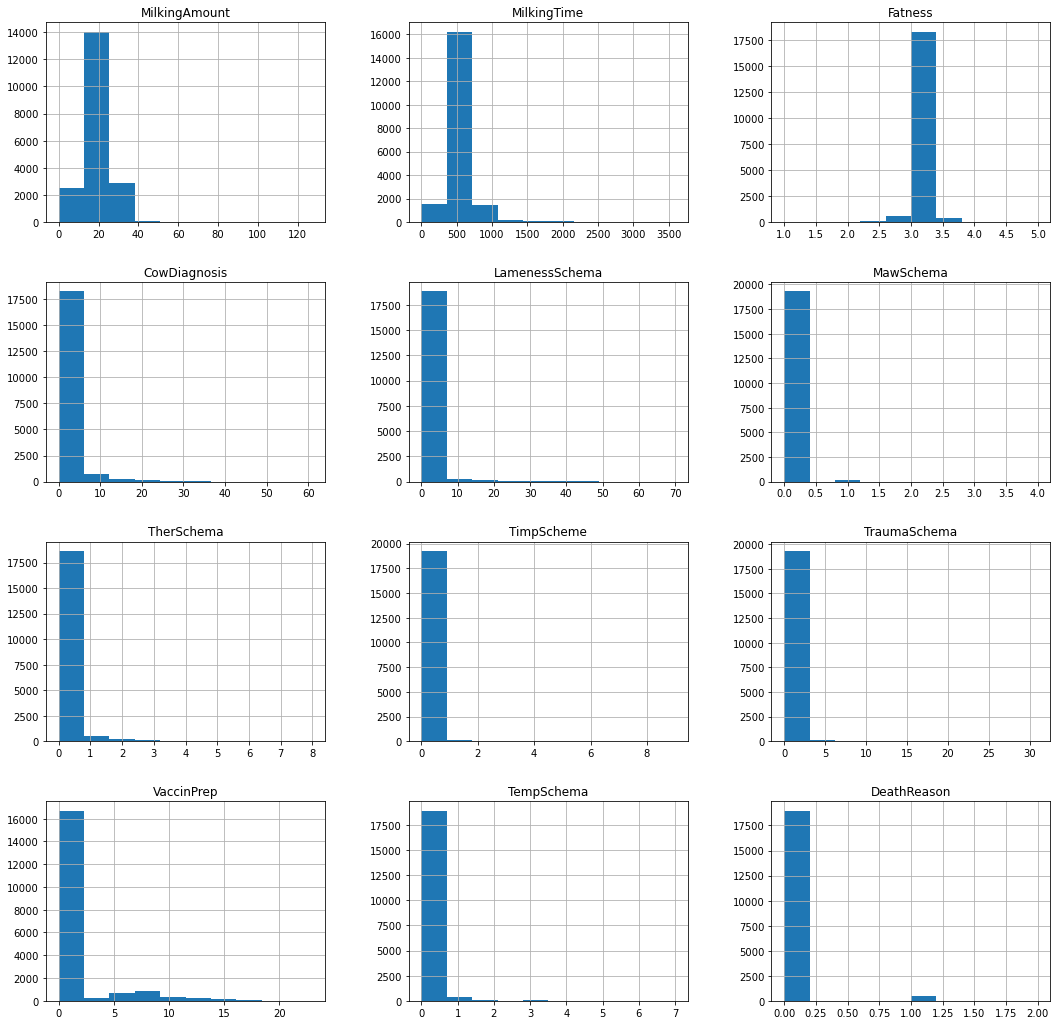

In [217]:
df_cow_all.hist(figsize=(18,18))
plt.show()

Матрица корреляции:

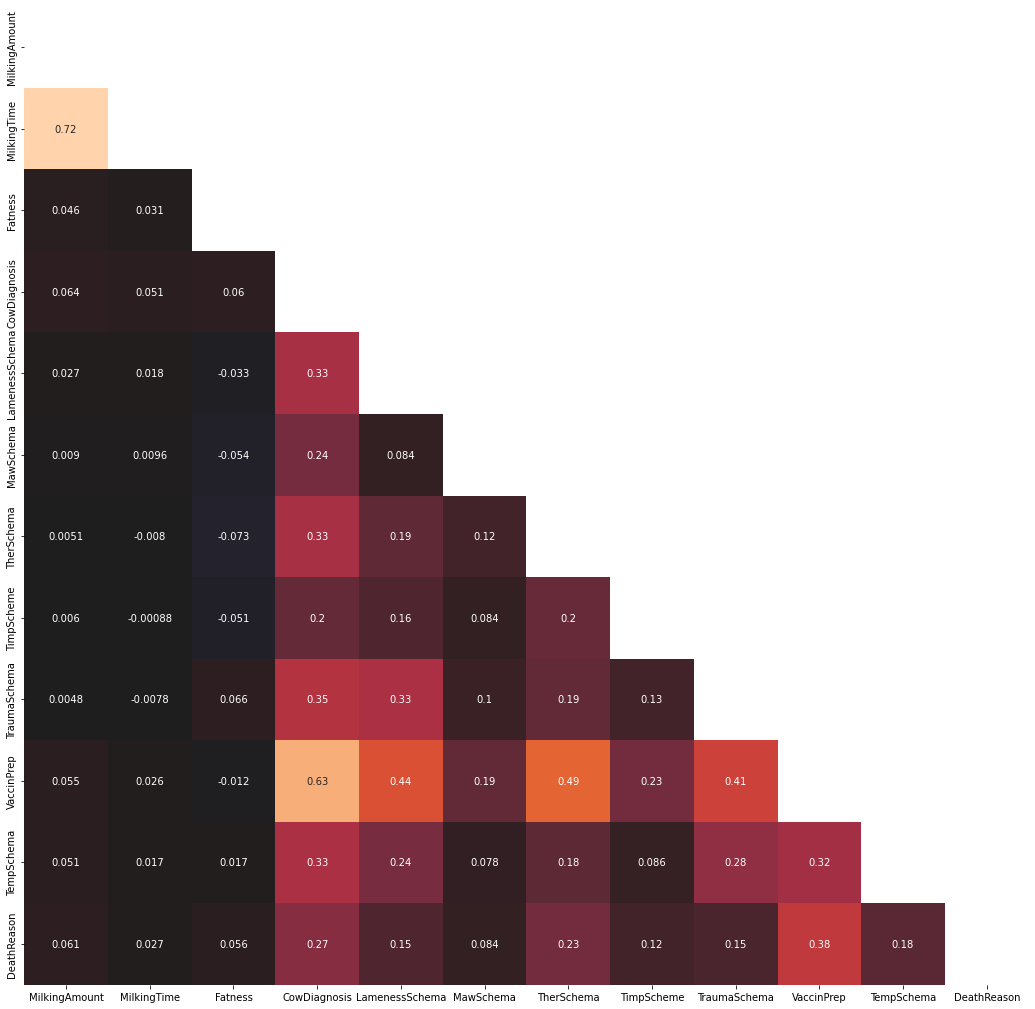

In [218]:
plt.figure(figsize=(18,18))

corr_matrix = df_cow_all.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

Функция для поиска оптимального количества кластеров методом локтя:

In [219]:
def elbow_checker(cluster_model, X):
    sns.reset_orig()
    k_max = 9
    inertia = []
    for k in range(2, k_max):
        kmeans = cluster_model(n_clusters=k).fit(X)
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.figure(figsize=(16, 8))
    plt.plot(range(2, k_max), inertia, marker='x')

    plt.xlabel('Количество кластеров k')
    plt.ylabel('Инерция')
    plt.grid()
    plt.show()

Функция для поиска оптимального количества кластеров методом силуэта:

In [220]:
def silhouette_checker(cluster_model, X):
    k_max = 9
    silhouette = []
    for k in tqdm(range(2, k_max)):
        agg = cluster_model(n_clusters=k).fit(X)
        labels = agg.labels_
        score = silhouette_score(X, labels)
        silhouette.append(score)
    plt.figure(figsize=(16, 8))
    plt.plot(range(2, k_max), silhouette, marker='x');
    plt.grid()

In [221]:
df_cow_all_copy = df_cow_all.copy()

In [222]:
df_cow_all_copy

CowID  MilkingAmount  MilkingTime   Fatness  CowDiagnosis  \
0      CZ0286619962      27.505851   699.792553  3.020573           0.0   
1      CZ0286629962      24.106886   681.643599  3.020573           0.0   
2      CZ0289130962      24.111459   671.255856  3.020573           0.0   
3      CZ0289133962      26.827136   593.428811  3.020573           0.0   
4      CZ0291447962      24.808152   694.121519  3.000000           4.0   
...             ...            ...          ...       ...           ...   
19466  US5347882024      19.856538   792.269231  2.900000           0.0   
19467  US5347882233      16.629825   697.530702  2.900000           0.0   
19468  US5347882659       5.862787   243.327869  2.900000           0.0   
19469  US5347882698      17.829463   539.508951  2.550000          25.0   
19470  US5347882719      17.510903   561.688963  3.250000          22.0   

       LamenessSchema  MawSchema  TherSchema  TimpScheme  TraumaSchema  \
0                 0.0        0.0         0.0         0.0           0.0   
1                 0.0        0.0         0.0         0.0           0.0   
2                 0.0        0.0         0.0         0.0           0.0   
3                 0.0        0.0         0.0         0.0           0.0   
4                 0.0        0.0         0.0         0.0           0.0   
...               ...        ...         ...         ...           ...   
19466             0.0        0.0         0.0         0.0           0.0   
19467             0.0        0.0         0.0         0.0           0.0   
19468             0.0        0.0         0.0         0.0           0.0   
19469             1.0        0.0         1.0         1.0           0.0   
19470             1.0        0.0         0.0         0.0           3.0   

       VaccinPrep  TempSchema  DeathReason  
0             0.0         0.0          0.0  
1             0.0         0.0          0.0  
2             0.0         0.0          0.0  
3             0.0         0.0          0.0  
4             4.0         0.0          0.0  
...           ...         ...          ...  
19466         0.0         0.0          0.0  
19467         0.0         0.0          0.0  
19468         0.0         0.0          0.0  
19469         7.0         0.0          0.0  
19470         8.0         0.0          0.0  

[19470 rows x 13 columns]

In [223]:
scaler = RobustScaler()
scaler = scaler.fit(df_cow_all_copy.drop(columns=['CowID'], axis=1))
df_normalized = scaler.fit_transform(df_cow_all_copy.drop(columns=['CowID'], axis=1))
df_normalized = pd.DataFrame(df_normalized, columns=df_cow_all_copy.drop(columns=['CowID'], axis=1).columns)

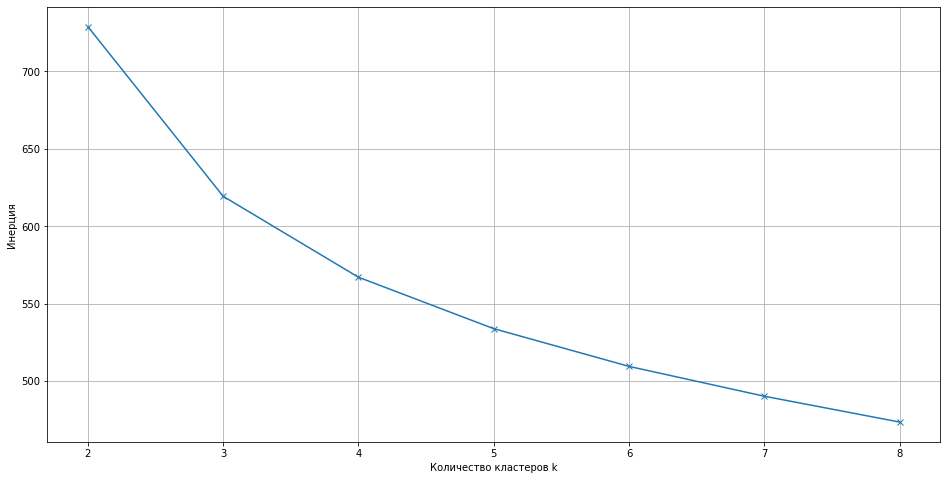

In [224]:
elbow_checker(KMeans, df_normalized)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.37s/it]


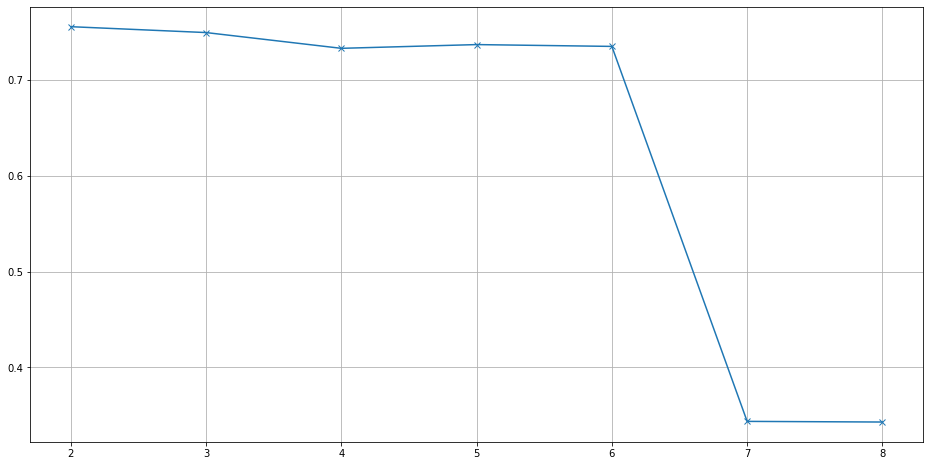

In [225]:
silhouette_checker(KMeans, df_normalized)

Итого для метода K-Means по результатам двух тестов оптимальное количество кластеров - 3

Попробуем определить оптимальный e для DBSCAN:

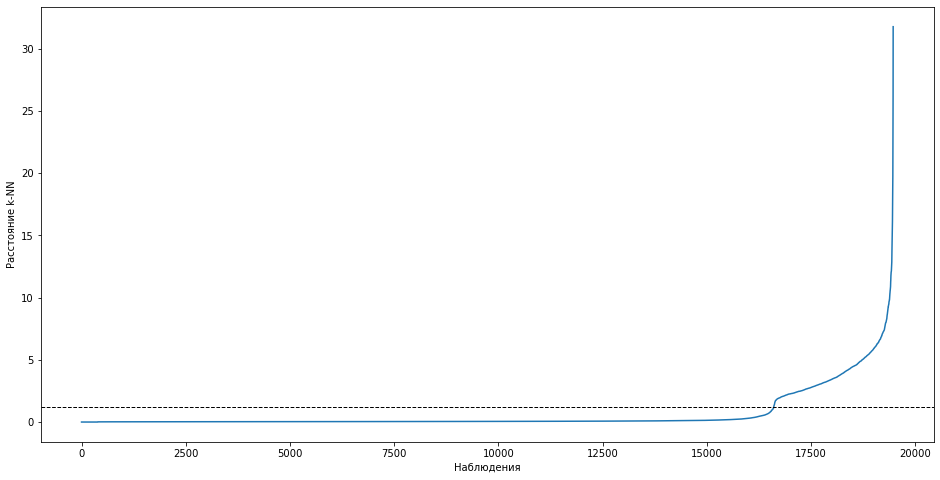

In [226]:
nbrs = NearestNeighbors(n_neighbors=df_normalized.shape[1]).fit(df_normalized)
neigh_dist, neigh_ind = nbrs.kneighbors(df_normalized)
sort_neigh_dist = np.sort(neigh_dist, axis=0)
k_dist = sort_neigh_dist[:, df_normalized.shape[1] - 1]
plt.figure(figsize=(16, 8))
plt.plot(k_dist)
plt.axhline(y=1.2, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("Расстояние k-NN")
plt.xlabel("Наблюдения")
plt.show()

Оптимальный e = 1.2

Проводим кластеризацию методом K-Means:

In [228]:
kmeans = KMeans(n_clusters=3, random_state=97)
df_cow_all['kmeans_cluster'] = kmeans.fit_predict(df_normalized)

In [229]:
unique, counts = np.unique(df_cow_all['kmeans_cluster'], return_counts=True)
print(f'Количество записей каждого кластера: {dict(zip(unique, counts))}')

Количество записей каждого кластера: {0: 16985, 1: 2095, 2: 390}


Проводим кластеризацию методом Oneclass SVM:

In [230]:
one_class_svm = OneClassSVM(nu=0.10, gamma='auto')
one_class_svm.fit(df_normalized)
svm_outliers = one_class_svm.predict(df_normalized)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])
df_cow_all['svm_cluster'] = svm_outliers

In [231]:
unique, counts = np.unique(df_cow_all['svm_cluster'], return_counts=True)
print(f'Количество записей каждого кластера: {dict(zip(unique, counts))}')

Количество записей каждого кластера: {0: 17142, 1: 2328}


Проводим кластеризацию методом DBSCAN:

In [553]:
dbscan = DBSCAN(eps=1.2, min_samples=df_normalized.shape[1] * 2)
df_cow_all['dbscan_cluster'] = dbscan.fit_predict(df_normalized)

In [554]:
unique, counts = np.unique(df_cow_all['dbscan_cluster'], return_counts=True)
print(f'Количество записей каждого кластера: {dict(zip(unique, counts))}')

Количество записей каждого кластера: {-1: 2860, 0: 156, 1: 13905, 2: 2549}


Проводим кластеризацию методом OPTICS:

In [555]:
optics = OPTICS(min_samples=df_normalized.shape[1] * 2, xi=0.07)  #xi=0.14
df_cow_all['optics_cluster'] = optics.fit_predict(df_normalized)

D:\Dev\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [556]:
unique, counts = np.unique(df_cow_all['optics_cluster'], return_counts=True)
print(f'Количество записей каждого кластера: {dict(zip(unique, counts))}')

Количество записей каждого кластера: {-1: 14750, 0: 80, 1: 69, 2: 31, 3: 401, 4: 1588, 5: 2551}


Отобразим полученные разными методами кластеры на плоскости:

In [557]:
tsne = TSNE(n_components=2, random_state=97, init='random', learning_rate='auto')
df_tsne = tsne.fit_transform(df_normalized)

In [558]:
plot_palette = 'viridis'

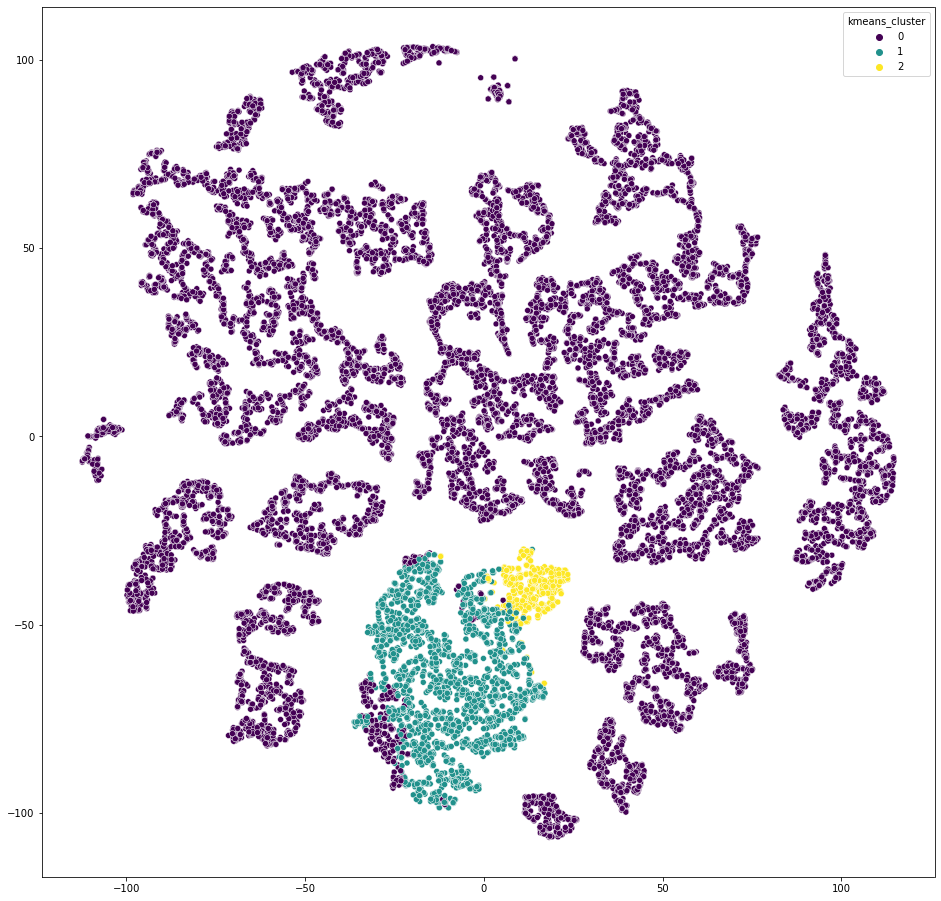

In [559]:
plt.figure(figsize=(16, 16))
sns.scatterplot(x = df_tsne[:, 0], y = df_tsne[:, 1], hue=df_cow_all['kmeans_cluster'], palette=plot_palette);

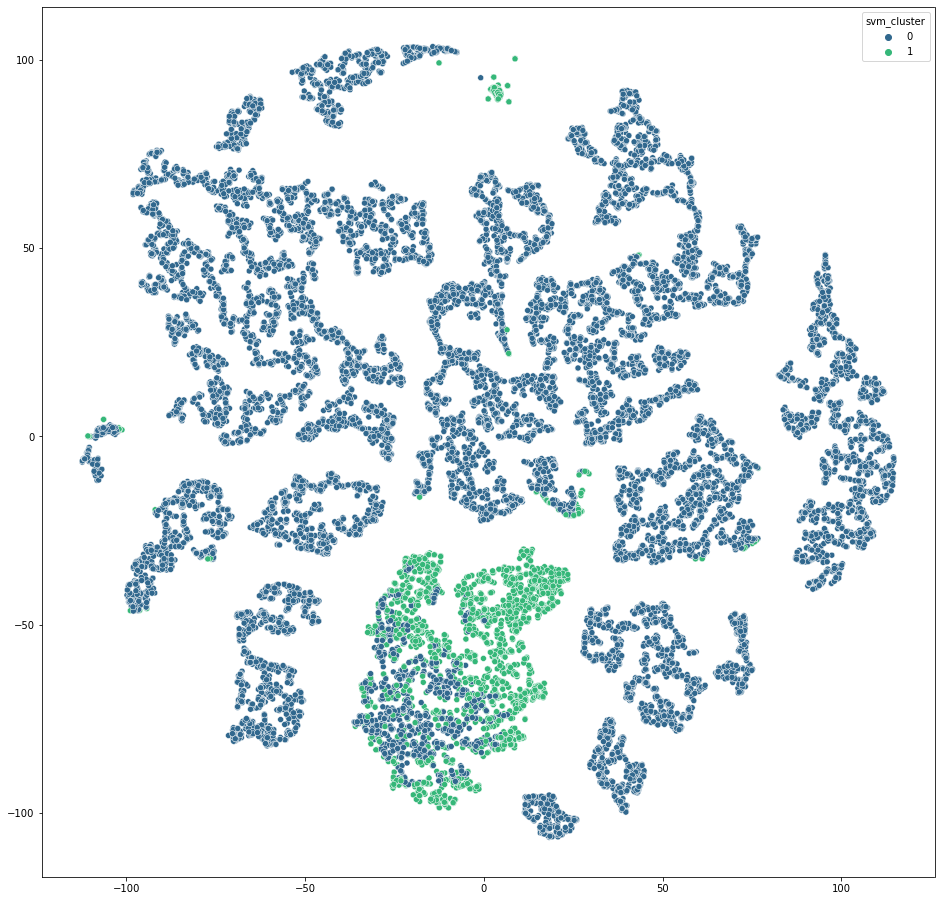

In [560]:
plt.figure(figsize=(16, 16))
sns.scatterplot(x = df_tsne[:, 0], y = df_tsne[:, 1], hue=df_cow_all['svm_cluster'], palette=plot_palette);

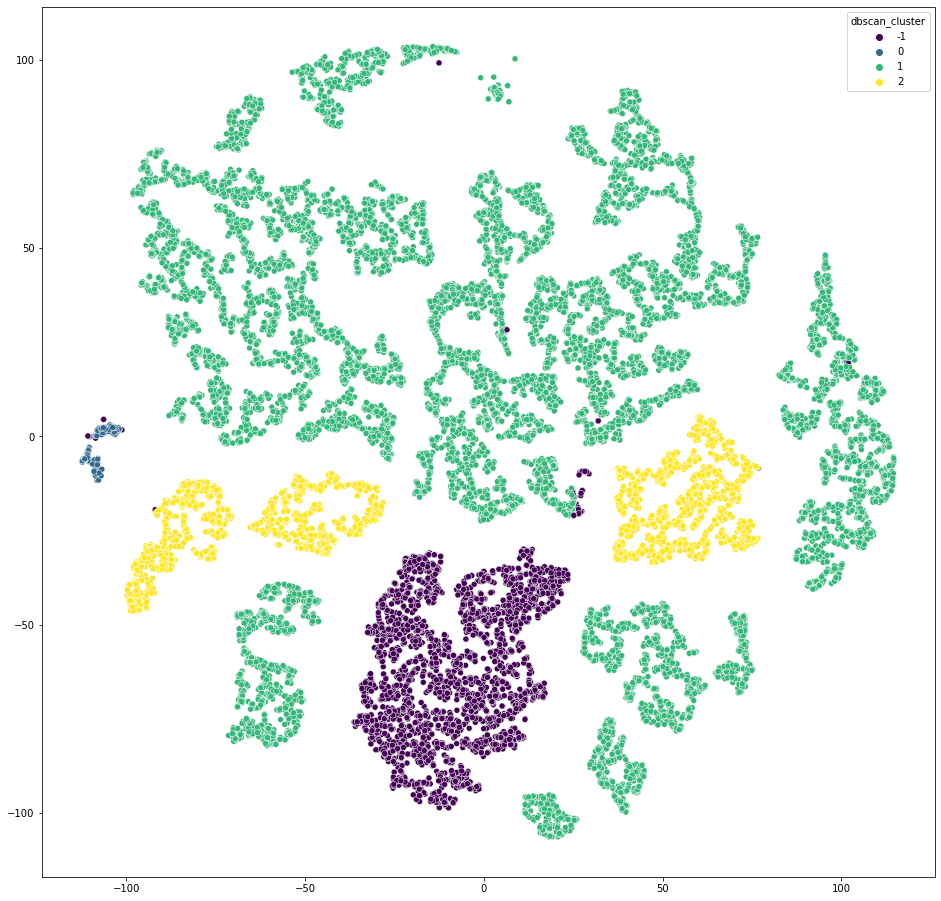

In [561]:
plt.figure(figsize=(16, 16))
sns.scatterplot(x = df_tsne[:, 0], y = df_tsne[:, 1], hue=df_cow_all['dbscan_cluster'], palette=plot_palette);

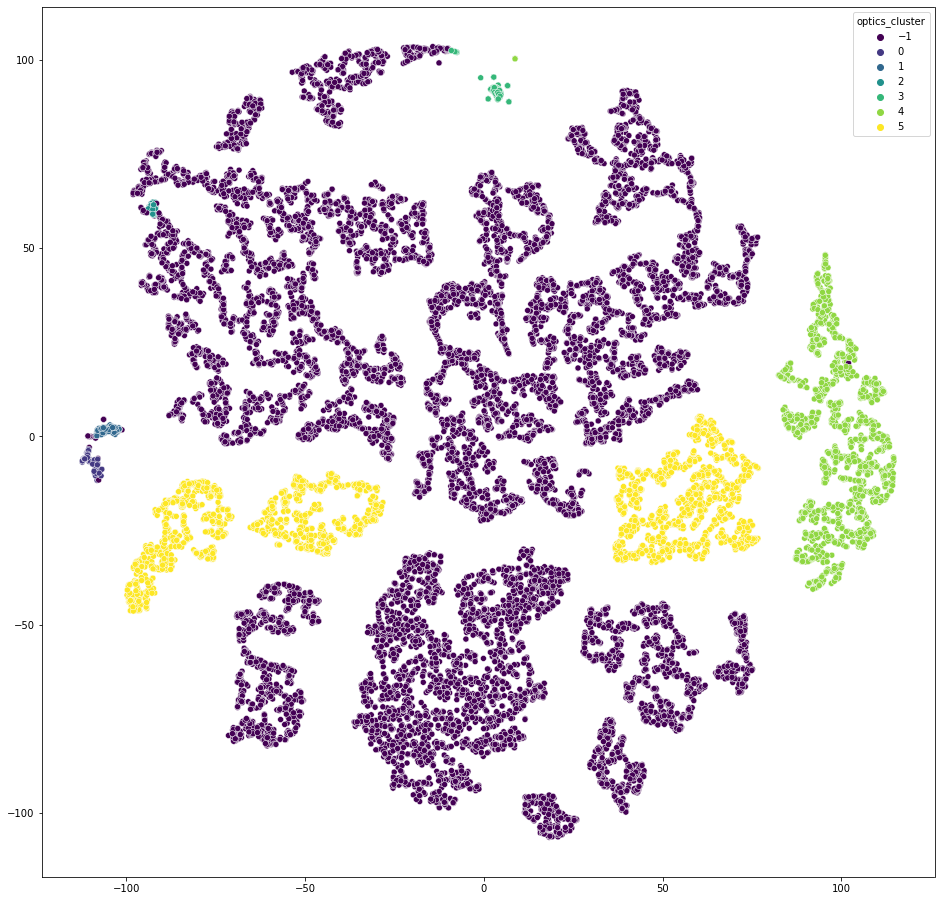

In [562]:
plt.figure(figsize=(16, 16))
sns.scatterplot(x = df_tsne[:, 0], y = df_tsne[:, 1], hue=df_cow_all['optics_cluster'], palette=plot_palette);

In [564]:
# plt.figure(figsize=(16, 16))
# sns.scatterplot(x = df_umap[:,0], y = df_umap[:,1], hue=df_cow_all['svm_cluster'], palette=plot_palette);

In [565]:
# df_cow_all_cluster_neg_1 = df_cow_all.loc[(df_cow_all['optics_cluster'] == -1)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)
# df_cow_all_cluster_0 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 0)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)
# df_cow_all_cluster_1 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 1)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)
# df_cow_all_cluster_2 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 2)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)
# df_cow_all_cluster_3 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 3)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)
# df_cow_all_cluster_4 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 4)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [566]:
feature_list = ['CowDiagnosis','LamenessSchema','MawSchema','TherSchema','TimpScheme','TraumaSchema','VaccinPrep','TempSchema','DeathReason']
# feature_list = ['CowDiagnosis','HealDays','LamenessSchema','LamenessDays','MawSchema','MawDays','TherSchema','TherDays','TimpScheme','TimpDays','TraumaSchema','TraumaDays','VaccinPrep','TempSchema','TempDays','DeathReason']
feature_list_ext = ['MilkingAmount', 'Fatness'] + feature_list

In [567]:
plt.rcParams['figure.figsize'] = (16, 12)

In [568]:
df_cow_all_present = df_cow_all.copy()

In [569]:
# df_cow_all_present.drop(columns=['HealDays', 
#                                    'LamenessDays', 
#                                    'MawDays', 
#                                    'TherDays', 
#                                    'TimpDays', 
#                                    'TraumaDays', 
#                                    'TempDays'
#                                 ], inplace=True)

In [570]:
df_cow_all_present.rename(columns={'CowID': 'ИД Животного', 
                                   'MilkingAmount': 'Средний надой', 
                                   'MilkingTime': 'Среднее время дойки', 
                                   'Fatness': 'Средняя упитанность', 
                                   'CowDiagnosis': 'Случаи заболевания', 
                                   'LamenessSchema': 'Случаи хромоты', 
                                   'MawSchema': 'Случаи смещения сычуга', 
                                   'TherSchema': 'Случаи терапии', 
                                   'TimpScheme': 'Случаи тимпании', 
                                   'TraumaSchema': 'Случаи травм', 
                                   'VaccinPrep': 'Вакцинация', 
                                   'TempSchema': 'Случаи повышенной температуры',
                                   'DeathReason': 'Смерть животного'
                                   }, inplace=True)

Анализ и интерпретация кластеров методом K-Means:

In [571]:
unique, counts = np.unique(df_cow_all['kmeans_cluster'], return_counts=True)
kmeans_dict = dict(zip(unique, counts))
print(f'Подсчет количества животных по каждому кластеру K-means:')
for key, value in kmeans_dict.items():
    print(f'Кластер {key} животных: {value} доля: {round(value * 100.0 / df_cow_all.shape[0], 2)} %')

Подсчет количества животных по каждому кластеру K-means:
Кластер 0 животных: 16985 доля: 87.24 %
Кластер 1 животных: 2095 доля: 10.76 %
Кластер 2 животных: 390 доля: 2.0 %


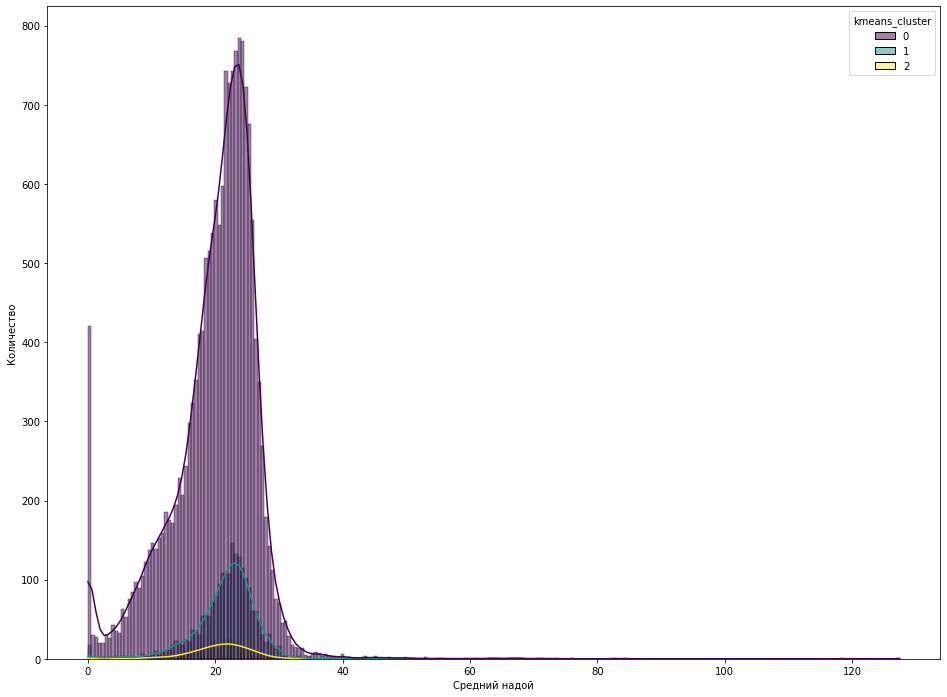

In [572]:
ax = sns.histplot(data=df_cow_all, kde=True,  x='MilkingAmount', palette='viridis', hue='kmeans_cluster');
ax.set(xlabel='Средний надой', ylabel='Количество')
plt.show();

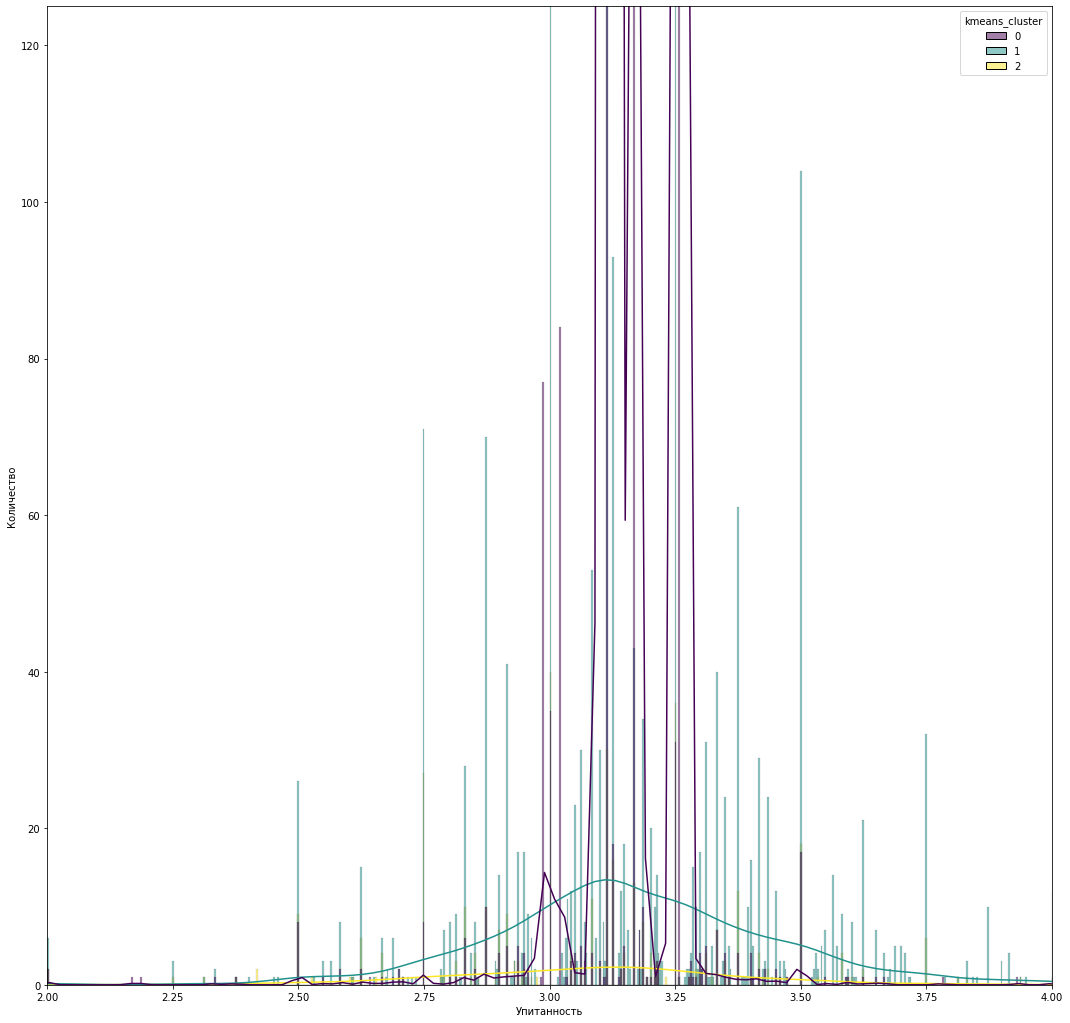

In [573]:
plt.figure(figsize=(18, 18))
ax = sns.histplot(data=df_cow_all, x='Fatness', kde=True, palette='viridis', hue='kmeans_cluster');
ax.set(xlabel='Упитанность', ylabel='Количество')
plt.ylim(0, 125)
plt.xlim(2, 4)
# ax.set_yscale('log')
plt.show();

In [574]:
# matplotlib.rc_file_defaults()
# plt.figure(figsize=(18,12))

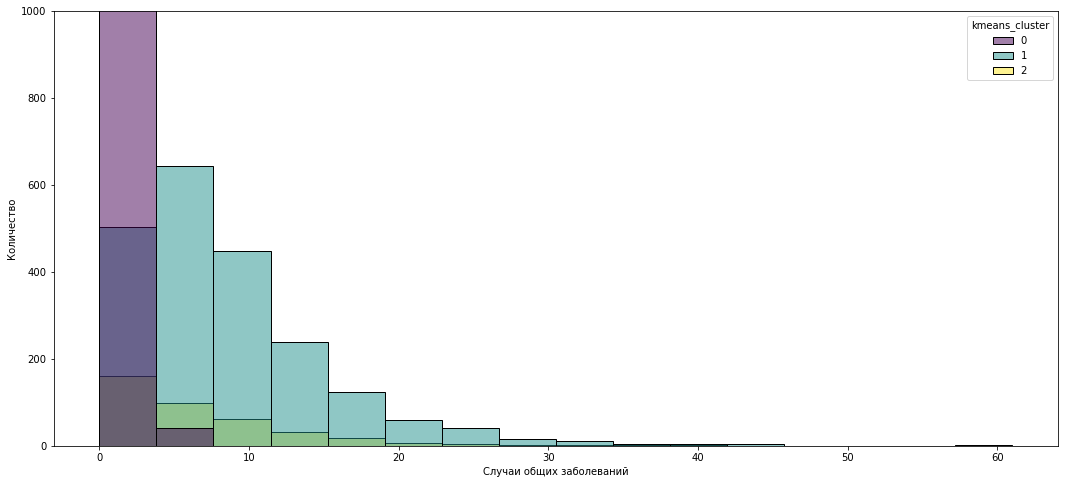

In [575]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(data=df_cow_all, x='CowDiagnosis', palette='viridis', hue='kmeans_cluster');
ax.set(xlabel='Случаи общих заболеваний', ylabel='Количество')
plt.ylim(0, 1000)
plt.show();

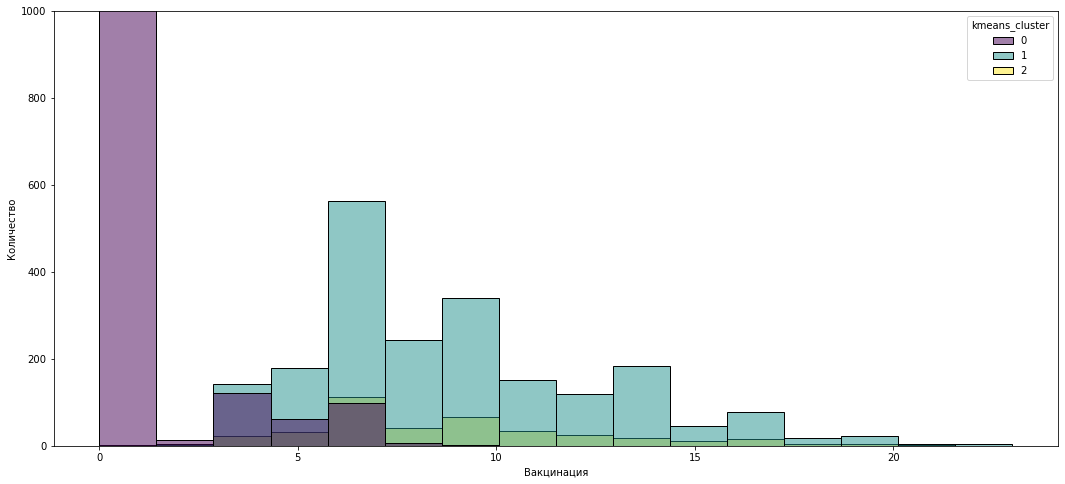

In [576]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(data=df_cow_all, x='VaccinPrep', palette='viridis', hue='kmeans_cluster');
ax.set(xlabel='Вакцинация', ylabel='Количество')
plt.ylim(0, 1000)
plt.show();

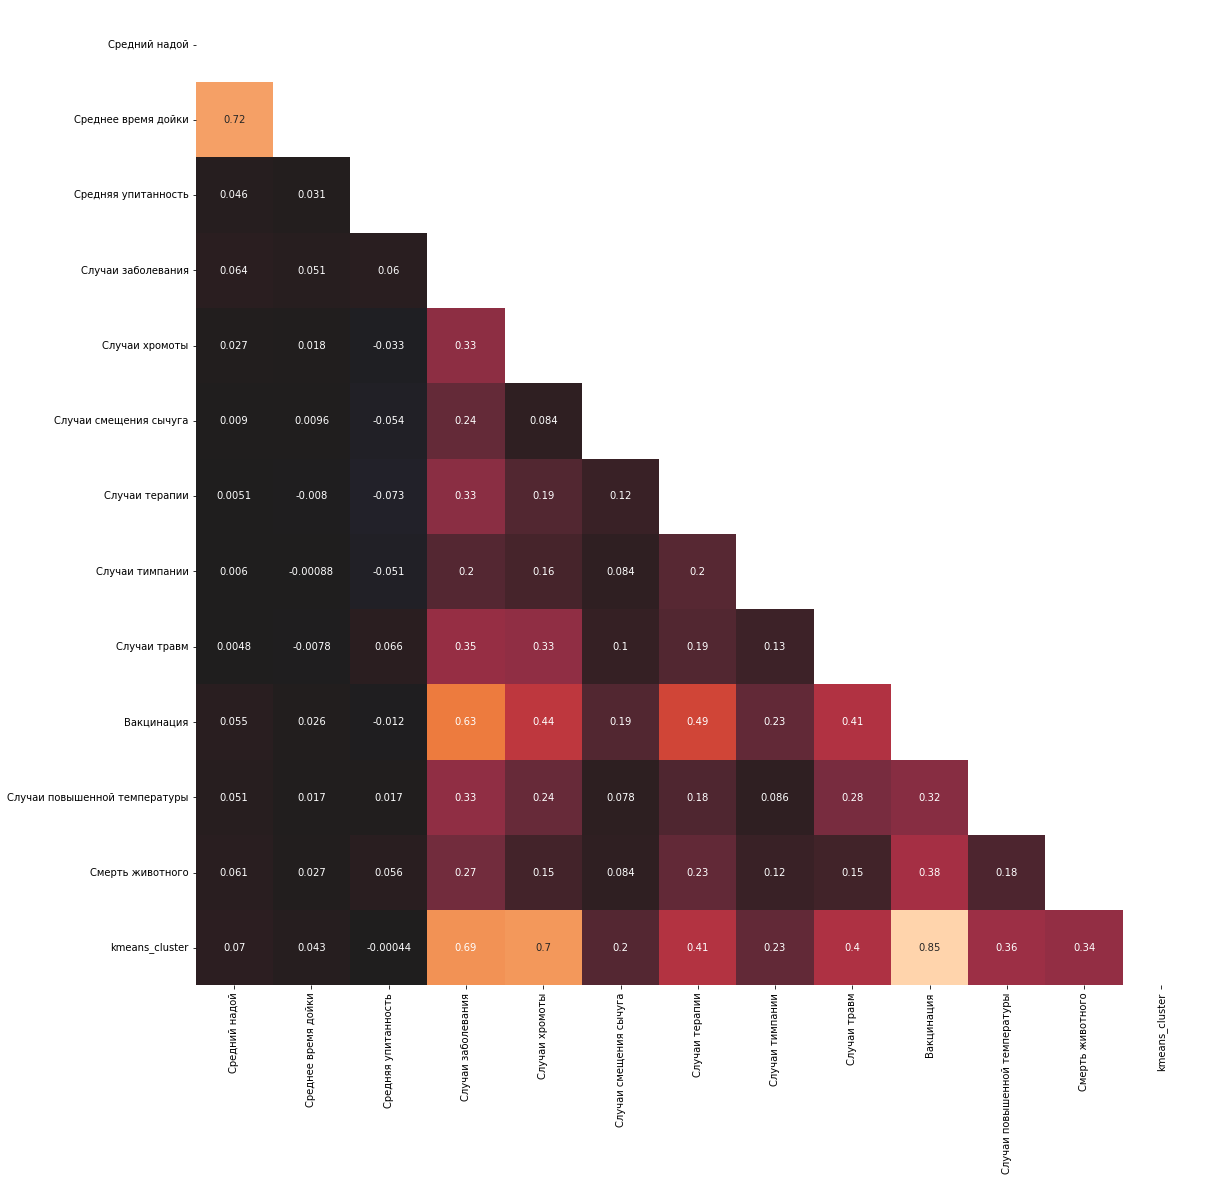

In [577]:
plt.figure(figsize=(18,18))

corr_matrix = df_cow_all_present.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster']).corr()   #.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster','kmeans_cluster'])
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

Анализ и интерпретация кластеров методом Oneclass SVM:

In [578]:
unique, counts = np.unique(df_cow_all['svm_cluster'], return_counts=True)
kmeans_dict = dict(zip(unique, counts))
print(f'Подсчет количества животных по каждому кластеру K-means:')
for key, value in kmeans_dict.items():
    print(f'Кластер {key} животных: {value} доля: {round(value * 100.0 / df_cow_all.shape[0], 2)} %')

Подсчет количества животных по каждому кластеру K-means:
Кластер 0 животных: 17142 доля: 88.04 %
Кластер 1 животных: 2328 доля: 11.96 %


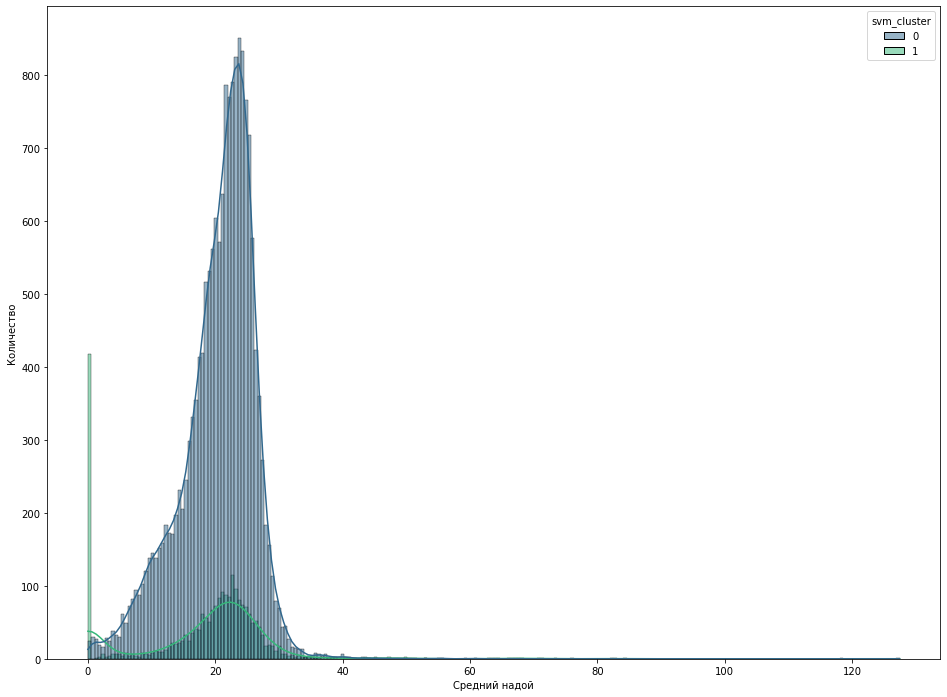

In [579]:
ax = sns.histplot(data=df_cow_all, kde=True,  x='MilkingAmount', palette='viridis', hue='svm_cluster');
ax.set(xlabel='Средний надой', ylabel='Количество')
plt.show();

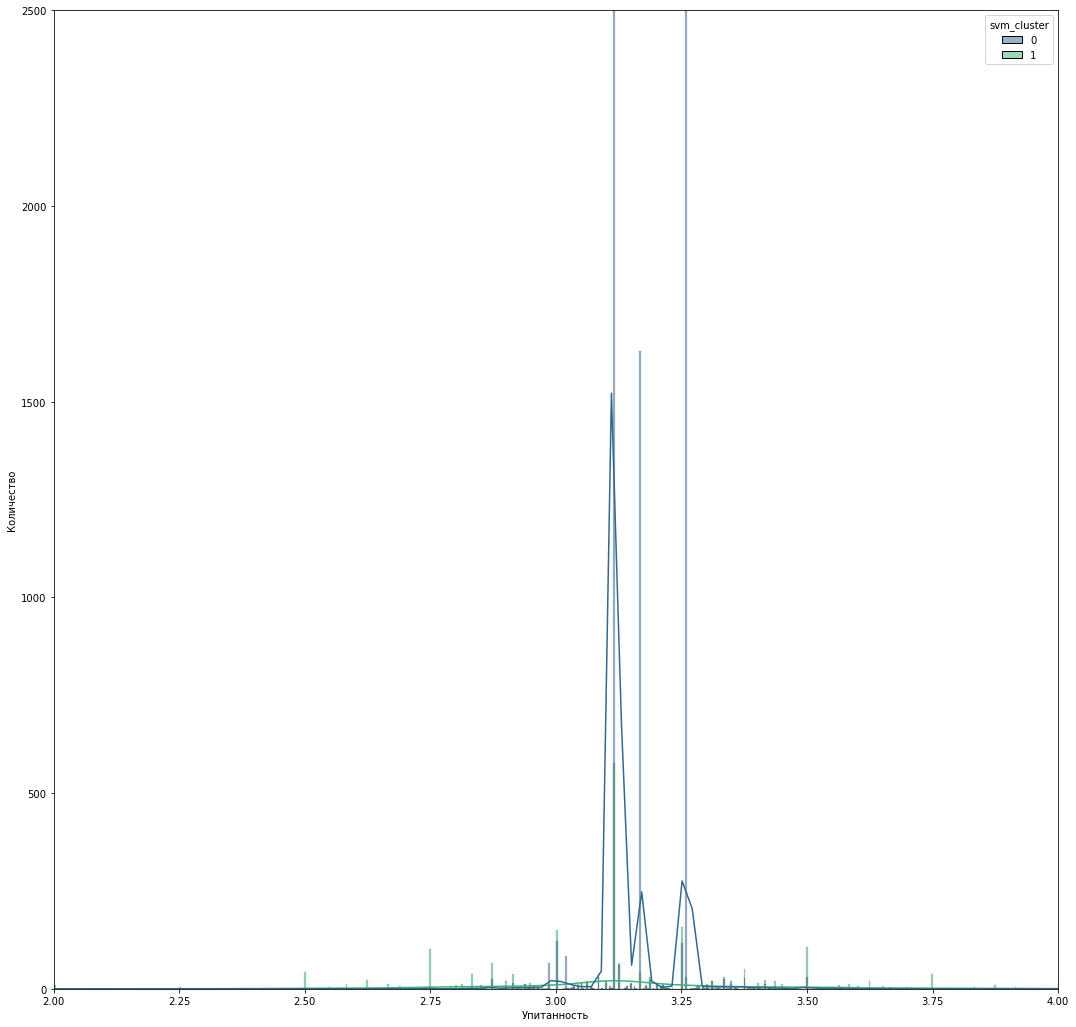

In [580]:
plt.figure(figsize=(18, 18))
ax = sns.histplot(data=df_cow_all, kde=True, x='Fatness', palette='viridis', hue='svm_cluster');
ax.set(xlabel='Упитанность', ylabel='Количество')
plt.ylim(0, 2500)
plt.xlim(2, 4)
# ax.set_yscale('log')
plt.show();

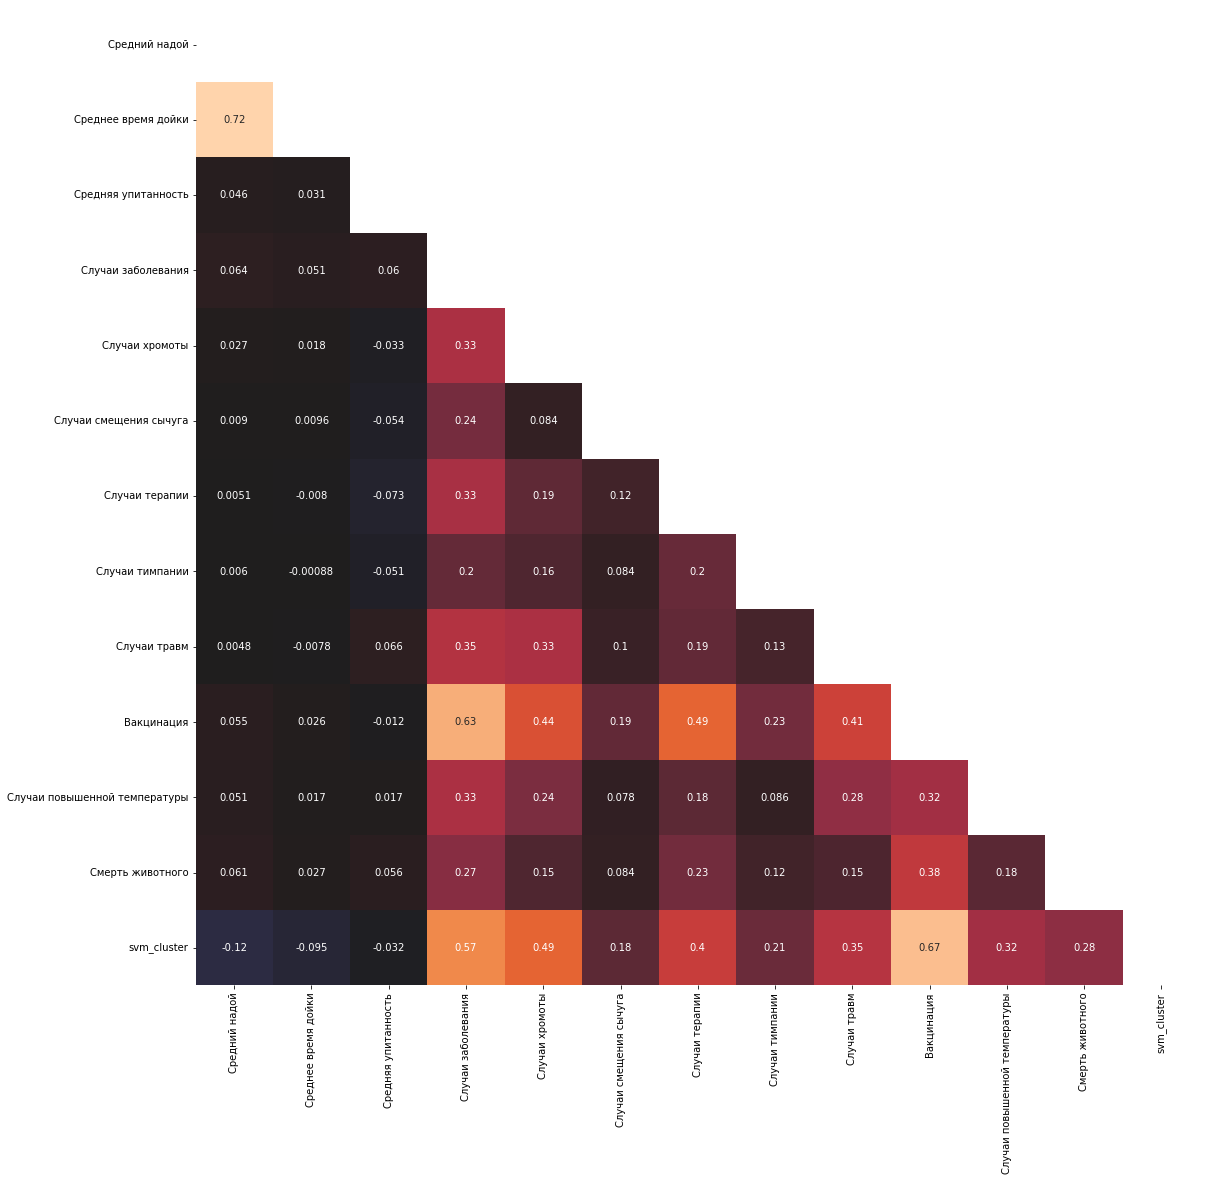

In [581]:
plt.figure(figsize=(18,18))

corr_matrix = df_cow_all_present.drop(columns=['dbscan_cluster','optics_cluster','kmeans_cluster']).corr()   #.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster','kmeans_cluster'])
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

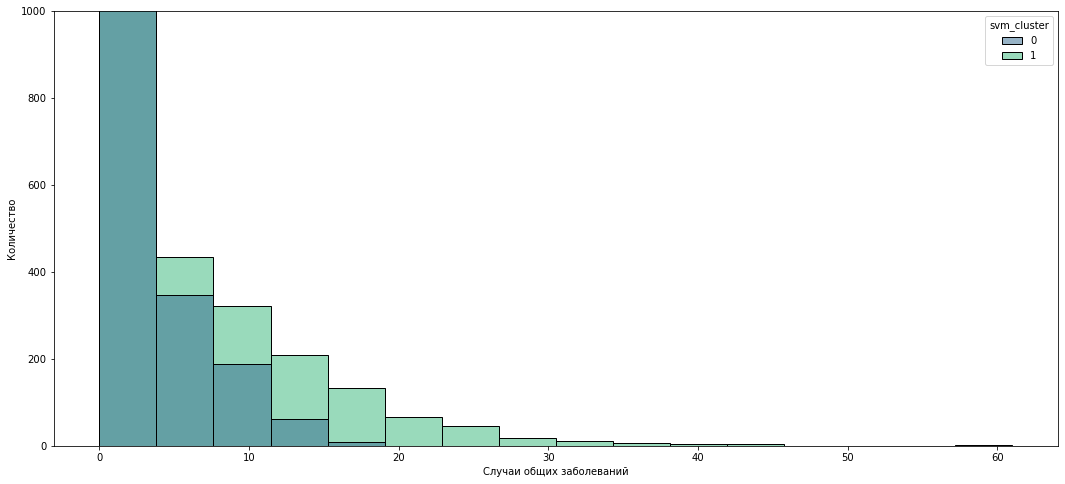

In [582]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(data=df_cow_all, x='CowDiagnosis', palette='viridis', hue='svm_cluster');
ax.set(xlabel='Случаи общих заболеваний', ylabel='Количество')
plt.ylim(0, 1000)
plt.show();

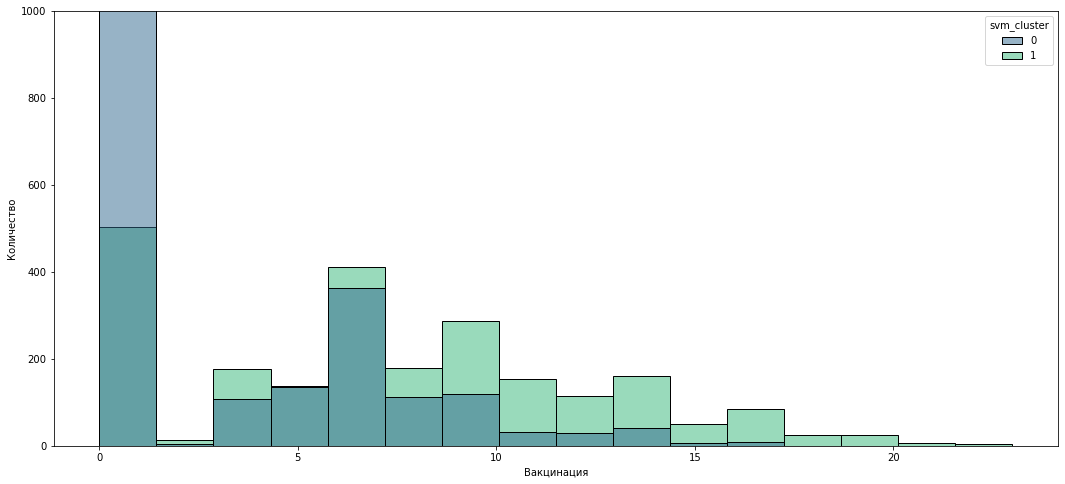

In [583]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(data=df_cow_all, x='VaccinPrep', palette='viridis', hue='svm_cluster');
ax.set(xlabel='Вакцинация', ylabel='Количество')
plt.ylim(0, 1000)
plt.show();

Анализ и интерпретация кластеров методом DBSCAN:

In [584]:
unique, counts = np.unique(df_cow_all['dbscan_cluster'], return_counts=True)
kmeans_dict = dict(zip(unique, counts))
print(f'Подсчет количества животных по каждому кластеру K-means:')
for key, value in kmeans_dict.items():
    print(f'Кластер {key} животных: {value} доля: {round(value * 100.0 / df_cow_all.shape[0], 2)} %')

Подсчет количества животных по каждому кластеру K-means:
Кластер -1 животных: 2860 доля: 14.69 %
Кластер 0 животных: 156 доля: 0.8 %
Кластер 1 животных: 13905 доля: 71.42 %
Кластер 2 животных: 2549 доля: 13.09 %


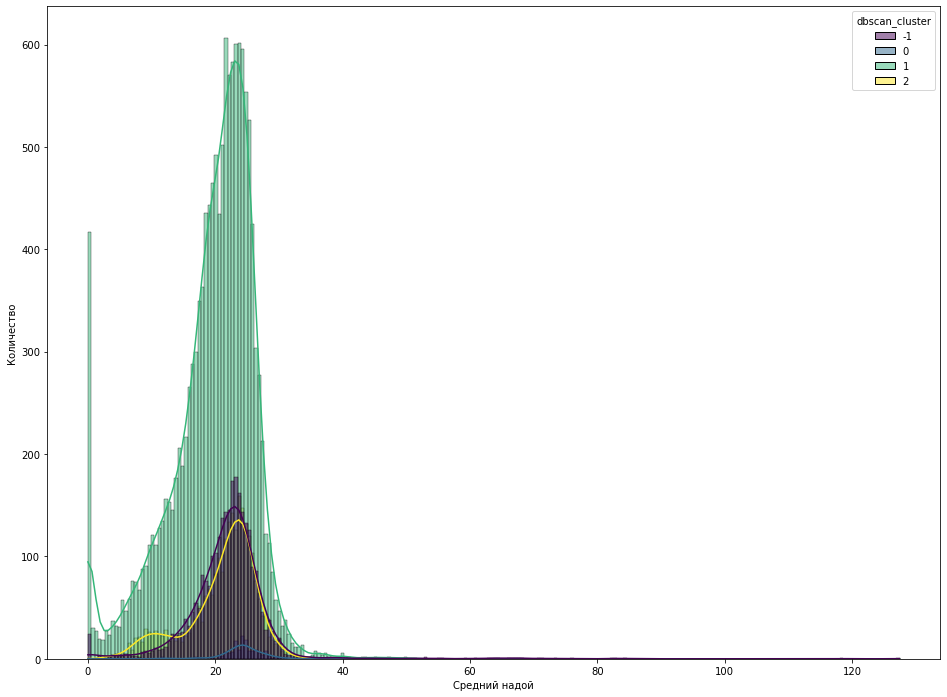

In [585]:
ax = sns.histplot(data=df_cow_all, kde=True,  x='MilkingAmount', palette='viridis', hue='dbscan_cluster');
ax.set(xlabel='Средний надой', ylabel='Количество')
plt.show();

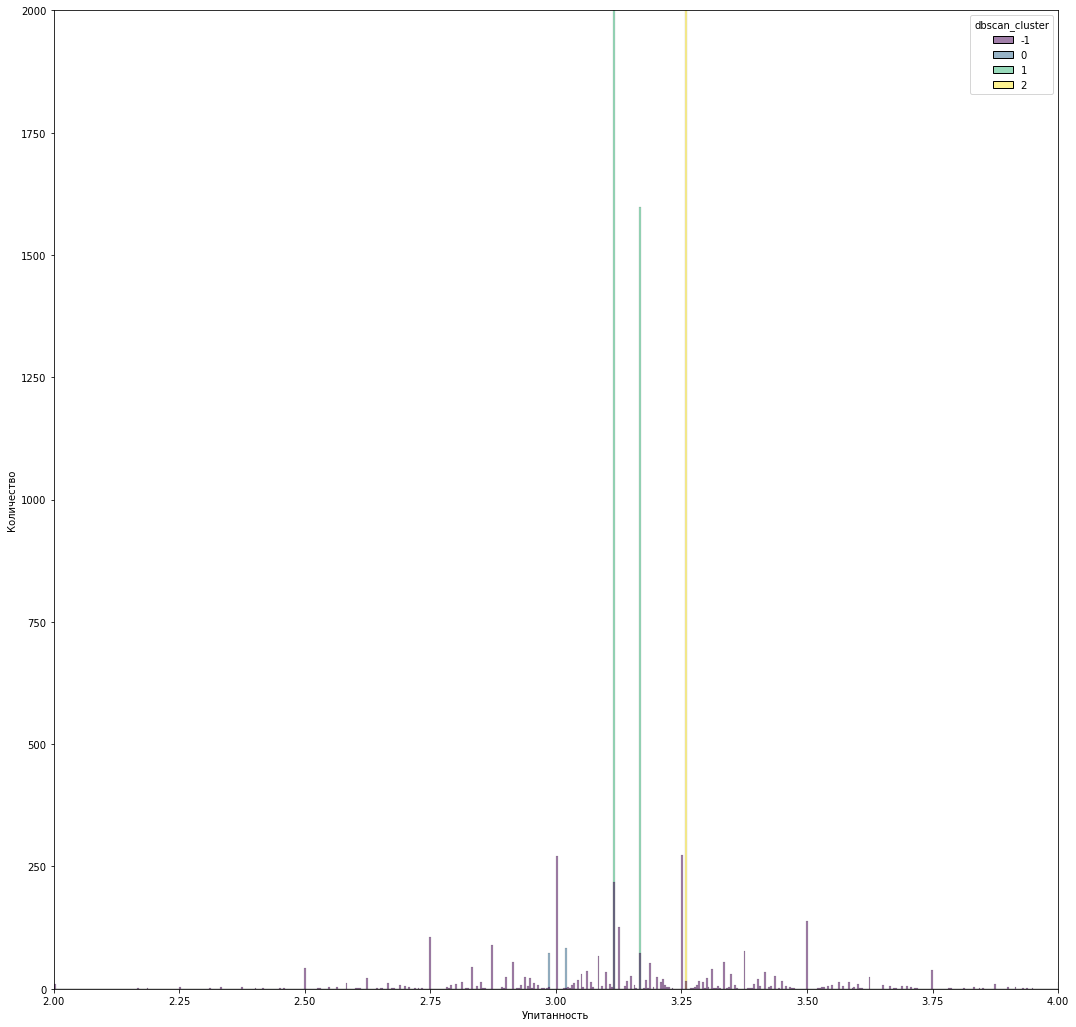

In [586]:
plt.figure(figsize=(18, 18))
ax = sns.histplot(data=df_cow_all, x='Fatness', palette='viridis', hue='dbscan_cluster');
ax.set(xlabel='Упитанность', ylabel='Количество')
plt.ylim(0, 2000)
plt.xlim(2, 4)
plt.show();

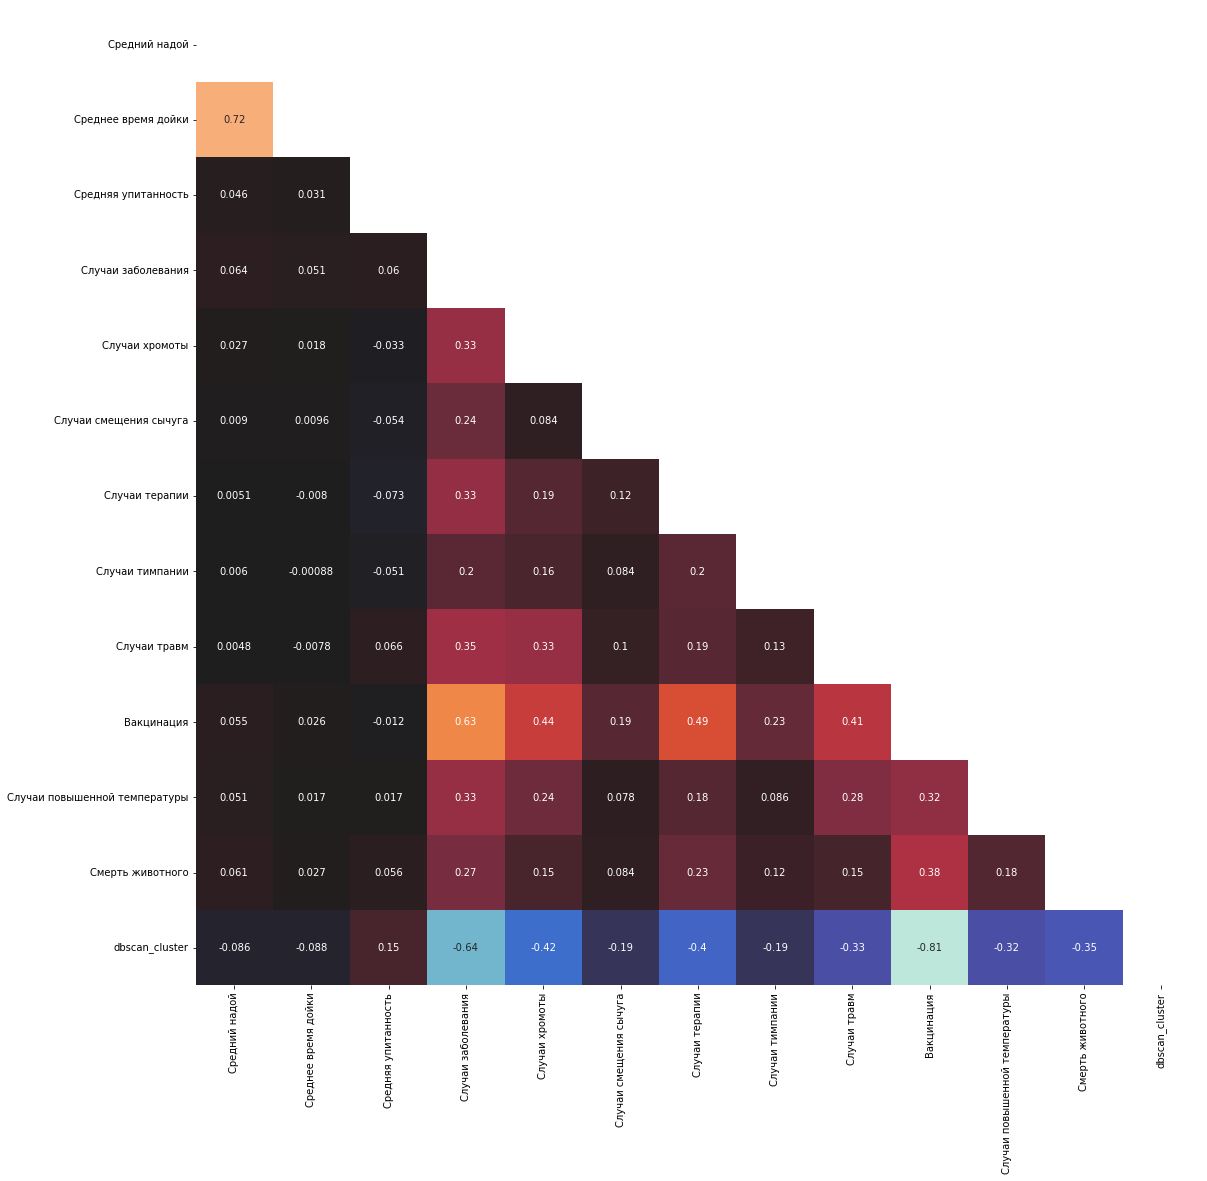

In [587]:
plt.figure(figsize=(18,18))

corr_matrix = df_cow_all_present.drop(columns=['svm_cluster','optics_cluster','kmeans_cluster']).corr()   #.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster','kmeans_cluster'])
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

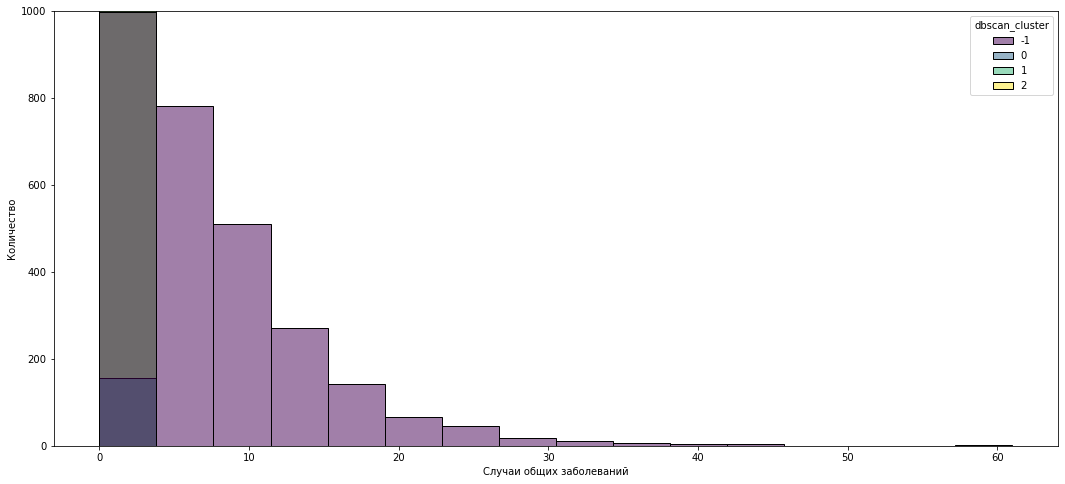

In [588]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(data=df_cow_all, x='CowDiagnosis', palette='viridis', hue='dbscan_cluster');
ax.set(xlabel='Случаи общих заболеваний', ylabel='Количество')
plt.ylim(0, 1000)
plt.show();

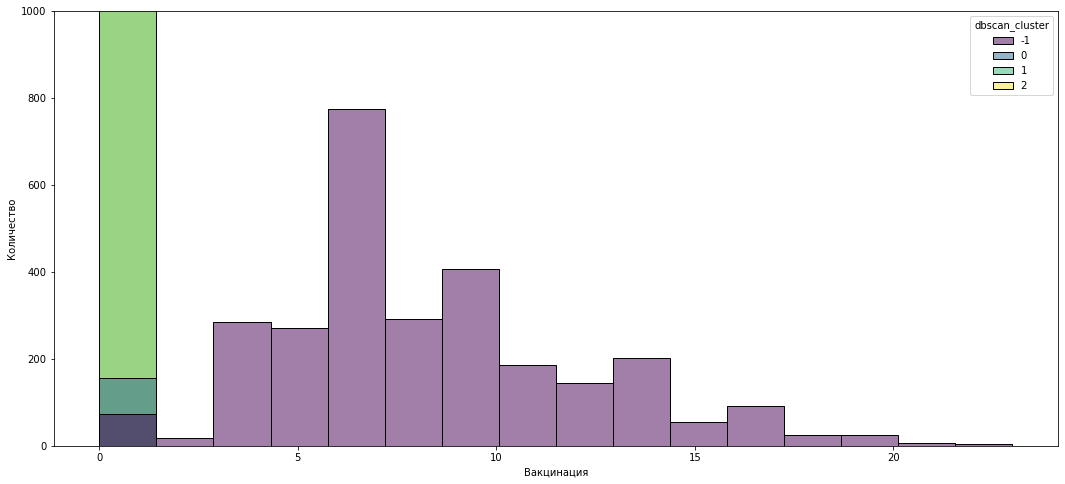

In [589]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(data=df_cow_all, x='VaccinPrep', palette='viridis', hue='dbscan_cluster');
ax.set(xlabel='Вакцинация', ylabel='Количество')
plt.ylim(0, 1000)
plt.show();

Анализ и интерпретация кластеров методом OPTICS:

In [590]:
unique, counts = np.unique(df_cow_all['optics_cluster'], return_counts=True)
kmeans_dict = dict(zip(unique, counts))
print(f'Подсчет количества животных по каждому кластеру K-means:')
for key, value in kmeans_dict.items():
    print(f'Кластер {key} животных: {value} доля: {round(value * 100.0 / df_cow_all.shape[0], 2)} %')

Подсчет количества животных по каждому кластеру K-means:
Кластер -1 животных: 14750 доля: 75.76 %
Кластер 0 животных: 80 доля: 0.41 %
Кластер 1 животных: 69 доля: 0.35 %
Кластер 2 животных: 31 доля: 0.16 %
Кластер 3 животных: 401 доля: 2.06 %
Кластер 4 животных: 1588 доля: 8.16 %
Кластер 5 животных: 2551 доля: 13.1 %


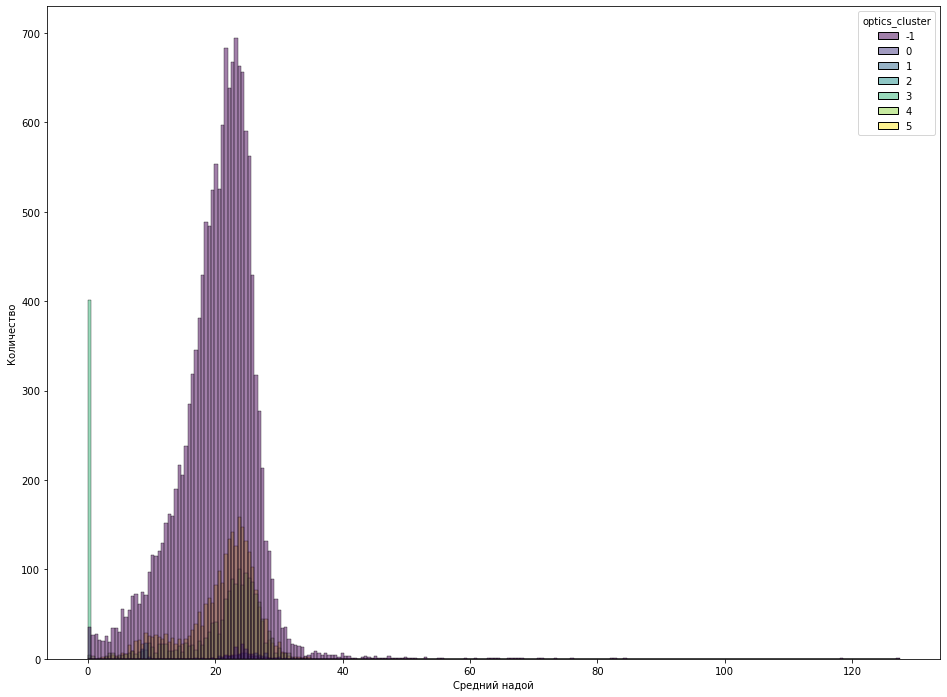

In [591]:
ax = sns.histplot(data=df_cow_all, x='MilkingAmount', palette='viridis', hue='optics_cluster');
ax.set(xlabel='Средний надой', ylabel='Количество')
plt.show();

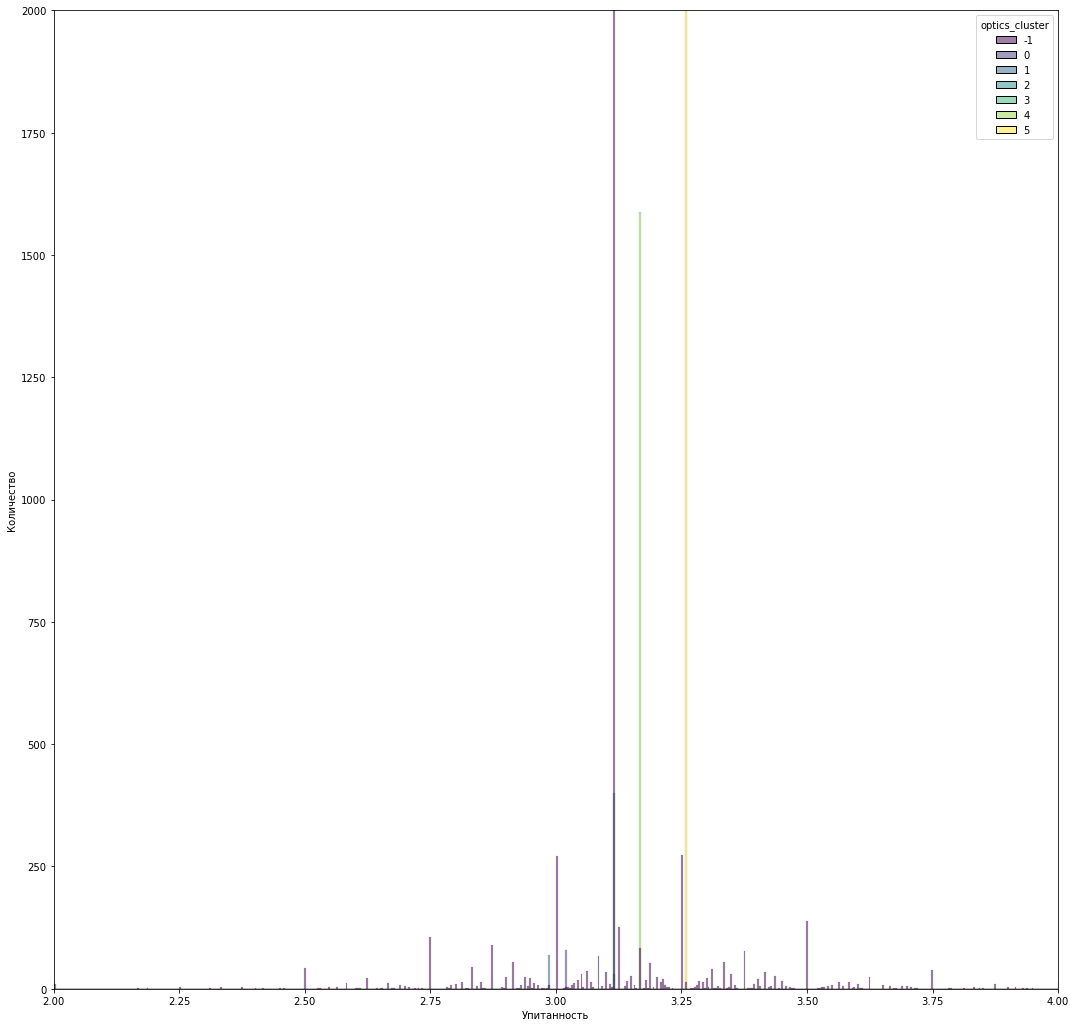

In [592]:
plt.figure(figsize=(18, 18))
ax = sns.histplot(data=df_cow_all, x='Fatness', palette='viridis', hue='optics_cluster');
ax.set(xlabel='Упитанность', ylabel='Количество')
plt.ylim(0, 2000)
plt.xlim(2, 4)
plt.show();

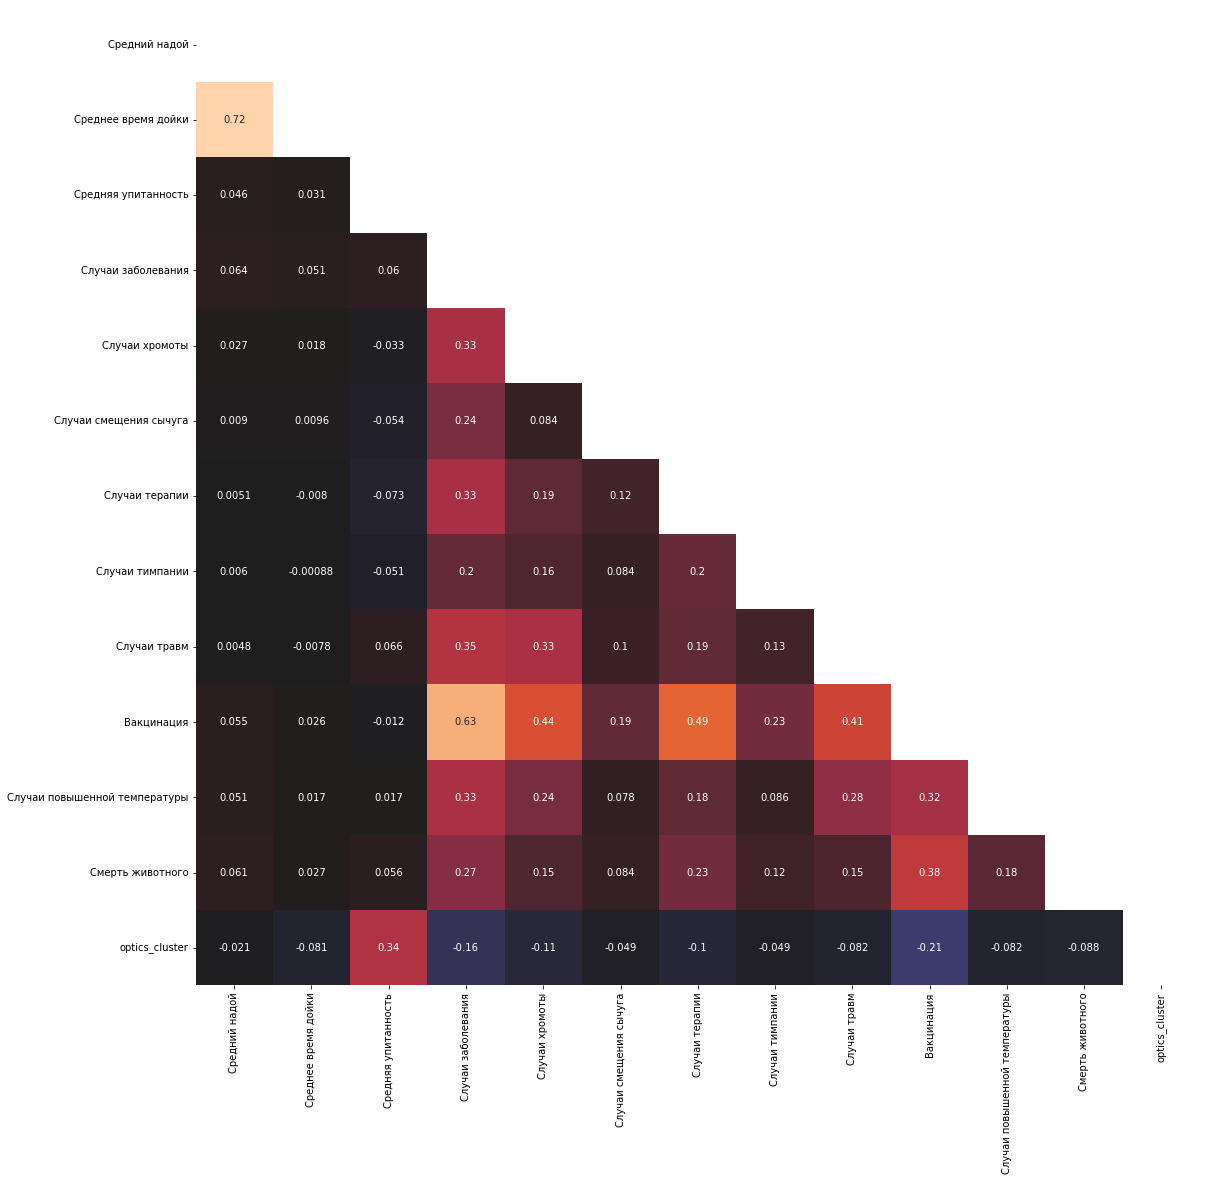

In [593]:
plt.figure(figsize=(18,18))

corr_matrix = df_cow_all_present.drop(columns=['svm_cluster','dbscan_cluster','kmeans_cluster']).corr()   #.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster','kmeans_cluster'])
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

Изобразим обущую матрицу корреляции, чтобы посмотреть на зависимость между кластерами, полученными разными методами:

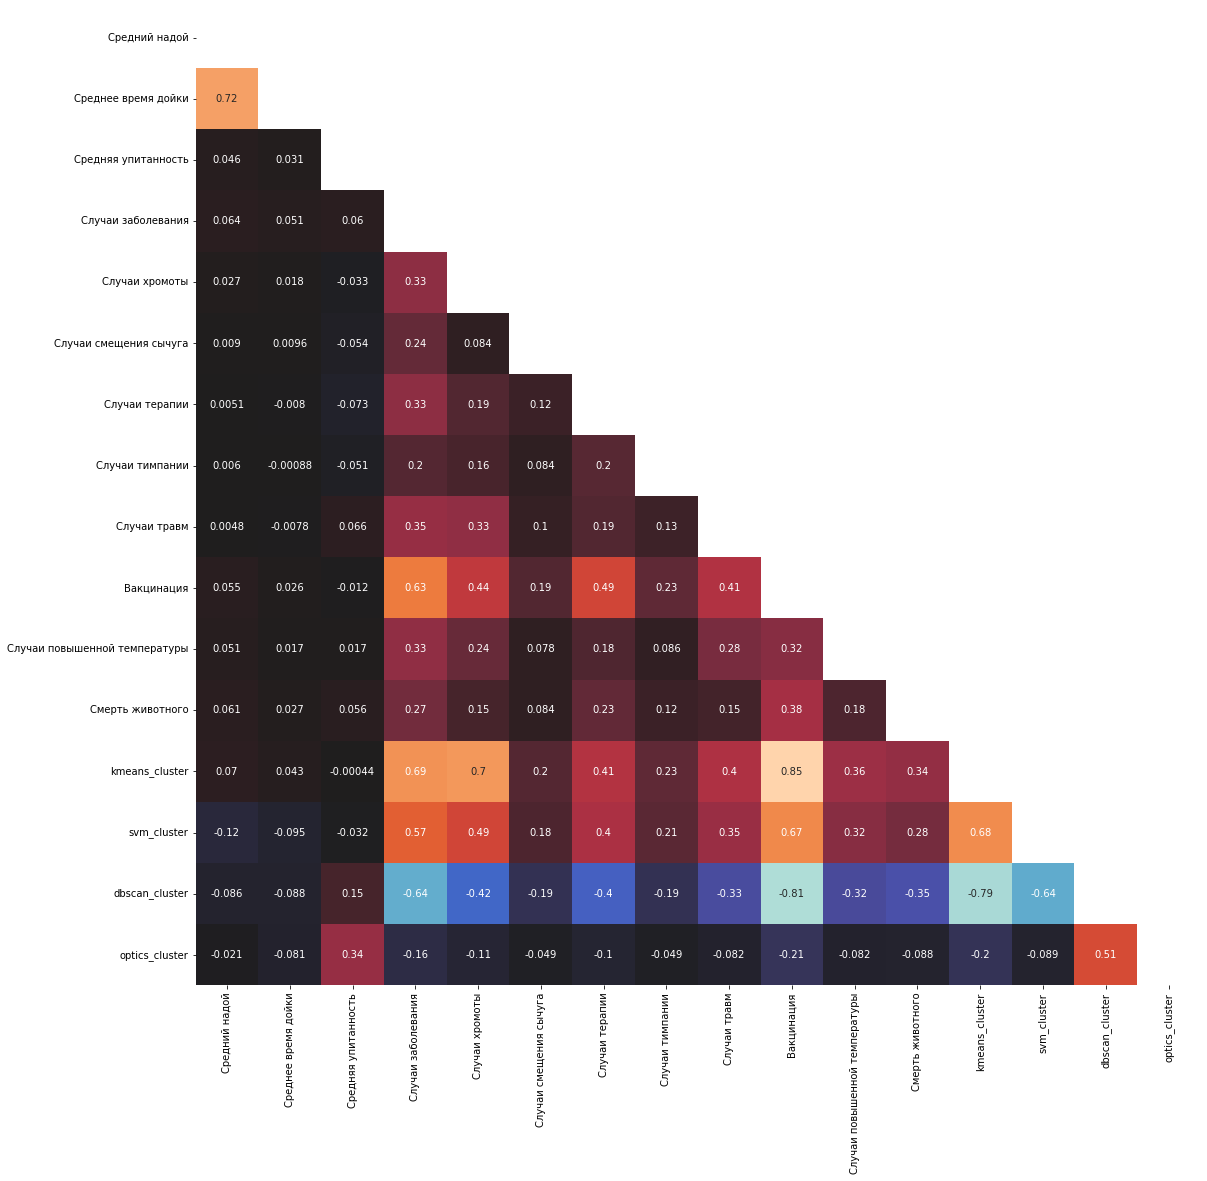

In [594]:
plt.figure(figsize=(18,18))

corr_matrix = df_cow_all_present.corr()   #.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster','kmeans_cluster'])
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

In [595]:
df_cow_all_optcluster_5 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 5)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [596]:
df_cow_all_optcluster_5.describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count    2551.000000  2551.000000  2.551000e+03        2551.0          2551.0   
mean       21.008050   583.320691  3.260219e+00           0.0             0.0   
std         5.534349   109.721326  3.775498e-14           0.0             0.0   
min         0.000000   114.500000  3.260219e+00           0.0             0.0   
25%        18.694837   523.930698  3.260219e+00           0.0             0.0   
50%        22.375843   602.922535  3.260219e+00           0.0             0.0   
75%        24.705180   657.998285  3.260219e+00           0.0             0.0   
max        34.707527  1097.181818  3.260219e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count     2551.0      2551.0      2551.0        2551.0      2551.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  
count      2551.0       2551.0  
mean          0.0          0.0  
std           0.0          0.0  
min           0.0          0.0  
25%           0.0          0.0  
50%           0.0          0.0  
75%           0.0          0.0  
max           0.0          0.0

In [597]:
df_cow_all_optcluster_4 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 4)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [598]:
df_cow_all_optcluster_4.describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count    1588.000000  1588.000000  1.588000e+03        1588.0          1588.0   
mean       21.688729   586.298956  3.167712e+00           0.0             0.0   
std         5.858514   115.196653  7.107666e-15           0.0             0.0   
min         0.000000     0.000000  3.167712e+00           0.0             0.0   
25%        19.677106   550.575964  3.167712e+00           0.0             0.0   
50%        23.246455   596.836391  3.167712e+00           0.0             0.0   
75%        25.532689   646.743304  3.167712e+00           0.0             0.0   
max        33.656439   985.666667  3.167712e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count     1588.0      1588.0      1588.0        1588.0      1588.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  
count      1588.0       1588.0  
mean          0.0          0.0  
std           0.0          0.0  
min           0.0          0.0  
25%           0.0          0.0  
50%           0.0          0.0  
75%           0.0          0.0  
max           0.0          0.0

In [599]:
df_cow_all_optcluster_3 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 3)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [600]:
df_cow_all_optcluster_3.describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count     401.000000   401.000000  4.010000e+02         401.0           401.0   
mean        0.006764     0.291754  3.116909e+00           0.0             0.0   
std         0.042902     1.817397  1.022681e-14           0.0             0.0   
min         0.000000     0.000000  3.116909e+00           0.0             0.0   
25%         0.000000     0.000000  3.116909e+00           0.0             0.0   
50%         0.000000     0.000000  3.116909e+00           0.0             0.0   
75%         0.000000     0.000000  3.116909e+00           0.0             0.0   
max         0.391905    16.571429  3.116909e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count      401.0       401.0       401.0         401.0       401.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  
count       401.0        401.0  
mean          0.0          0.0  
std           0.0          0.0  
min           0.0          0.0  
25%           0.0          0.0  
50%           0.0          0.0  
75%           0.0          0.0  
max           0.0          0.0

In [601]:
df_cow_all_optcluster_2 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 2)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [602]:
df_cow_all_optcluster_2.describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count      31.000000    31.000000  3.100000e+01          31.0            31.0   
mean        8.959616   384.775866  3.116909e+00           0.0             0.0   
std         0.270495     6.418704  4.514300e-16           0.0             0.0   
min         8.550375   372.415842  3.116909e+00           0.0             0.0   
25%         8.703295   380.033454  3.116909e+00           0.0             0.0   
50%         8.931200   383.607843  3.116909e+00           0.0             0.0   
75%         9.154418   390.137218  3.116909e+00           0.0             0.0   
max         9.494891   395.212121  3.116909e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count       31.0        31.0        31.0          31.0        31.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  
count        31.0         31.0  
mean          0.0          0.0  
std           0.0          0.0  
min           0.0          0.0  
25%           0.0          0.0  
50%           0.0          0.0  
75%           0.0          0.0  
max           0.0          0.0

In [603]:
df_cow_all_optcluster_1 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 1)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [604]:
df_cow_all_optcluster_1.describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count      69.000000    69.000000  6.900000e+01          69.0            69.0   
mean       24.995680   613.981960  2.985843e+00           0.0             0.0   
std         2.947145    54.514775  1.342028e-15           0.0             0.0   
min        17.050000   518.082759  2.985843e+00           0.0             0.0   
25%        23.009305   572.620072  2.985843e+00           0.0             0.0   
50%        24.969910   615.875000  2.985843e+00           0.0             0.0   
75%        27.035185   640.720070  2.985843e+00           0.0             0.0   
max        31.996111   735.711111  2.985843e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count       69.0        69.0        69.0          69.0        69.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  
count        69.0         69.0  
mean          0.0          0.0  
std           0.0          0.0  
min           0.0          0.0  
25%           0.0          0.0  
50%           0.0          0.0  
75%           0.0          0.0  
max           0.0          0.0

In [605]:
df_cow_all_optcluster_0 = df_cow_all.loc[(df_cow_all['optics_cluster'] == 0)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [606]:
df_cow_all_optcluster_0.describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count      80.000000    80.000000  8.000000e+01          80.0            80.0   
mean       24.219700   644.692312  3.020573e+00           0.0             0.0   
std         1.767674    54.431810  5.809584e-15           0.0             0.0   
min        19.447778   499.414516  3.020573e+00           0.0             0.0   
25%        23.331537   600.764621  3.020573e+00           0.0             0.0   
50%        24.132134   664.033386  3.020573e+00           0.0             0.0   
75%        25.028138   686.217308  3.020573e+00           0.0             0.0   
max        29.665741   749.068966  3.020573e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count       80.0        80.0        80.0          80.0        80.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  
count        80.0         80.0  
mean          0.0          0.0  
std           0.0          0.0  
min           0.0          0.0  
25%           0.0          0.0  
50%           0.0          0.0  
75%           0.0          0.0  
max           0.0          0.0

In [607]:
df_cow_all_optcluster_main = df_cow_all.loc[(df_cow_all['optics_cluster'] == -1)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [608]:
df_cow_all_optcluster_main.describe()

MilkingAmount   MilkingTime       Fatness  CowDiagnosis  \
count   14750.000000  14750.000000  14750.000000  14750.000000   
mean       20.327726    588.107517      3.122699      1.379322   
std         6.207570    191.636642      0.128260      4.046602   
min         0.000000      0.000000      1.000000      0.000000   
25%        17.299249    503.364272      3.116909      0.000000   
50%        21.214258    594.099239      3.116909      0.000000   
75%        24.097345    661.175369      3.116909      0.000000   
max       127.435500   3592.700000      5.000000     61.000000   

       LamenessSchema     MawSchema    TherSchema    TimpScheme  TraumaSchema  \
count    14750.000000  14750.000000  14750.000000  14750.000000  14750.000000   
mean         0.951593      0.013085      0.092000      0.020407      0.161627   
std          4.285567      0.128747      0.437431      0.200828      0.942106   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          0.000000      0.000000      0.000000      0.000000      0.000000   
50%          0.000000      0.000000      0.000000      0.000000      0.000000   
75%          0.000000      0.000000      0.000000      0.000000      0.000000   
max         70.000000      4.000000      8.000000      9.000000     31.000000   

         VaccinPrep    TempSchema   DeathReason  
count  14750.000000  14750.000000  14750.000000  
mean       1.601627      0.055525      0.033288  
std        3.676390      0.327044      0.181274  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max       23.000000      7.000000      2.000000

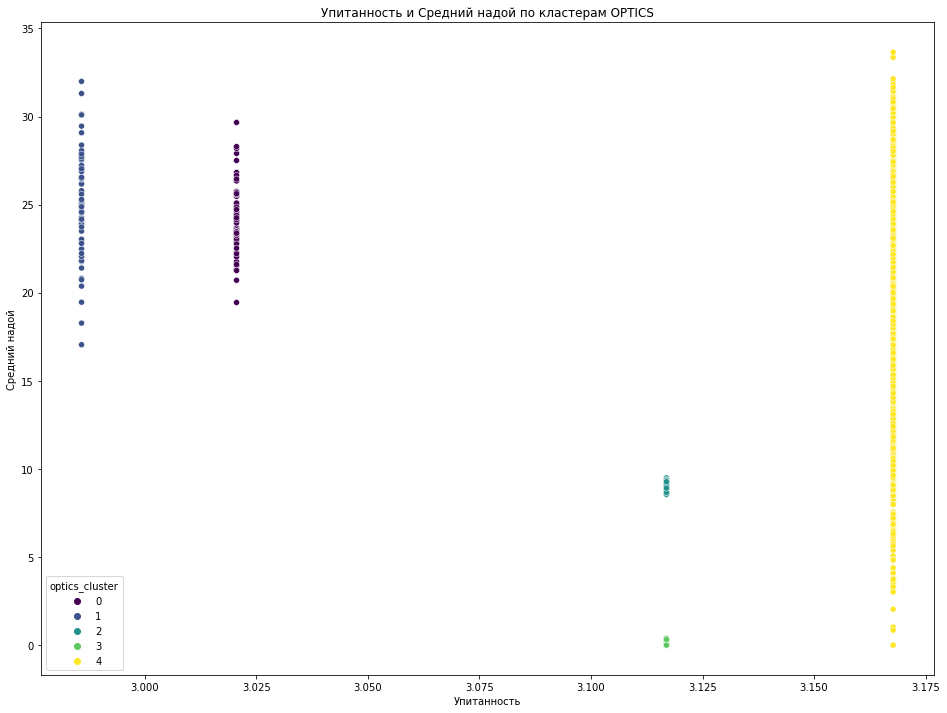

In [609]:
ax = sns.scatterplot(x='Fatness', y='MilkingAmount', hue='optics_cluster', data=df_cow_all.loc[(df_cow_all['optics_cluster'] >= 0) & (df_cow_all['optics_cluster'] != 5)], palette='viridis')
ax.set_title('Упитанность и Средний надой по кластерам OPTICS')
ax.set_ylabel('Средний надой');
ax.set_xlabel('Упитанность');

In [610]:
df_cow_all.loc[(df_cow_all['optics_cluster'] == 2)].describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count      31.000000    31.000000  3.100000e+01          31.0            31.0   
mean        8.959616   384.775866  3.116909e+00           0.0             0.0   
std         0.270495     6.418704  4.514300e-16           0.0             0.0   
min         8.550375   372.415842  3.116909e+00           0.0             0.0   
25%         8.703295   380.033454  3.116909e+00           0.0             0.0   
50%         8.931200   383.607843  3.116909e+00           0.0             0.0   
75%         9.154418   390.137218  3.116909e+00           0.0             0.0   
max         9.494891   395.212121  3.116909e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count       31.0        31.0        31.0          31.0        31.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  kmeans_cluster  svm_cluster  dbscan_cluster  \
count        31.0         31.0            31.0         31.0            31.0   
mean          0.0          0.0             0.0          0.0             1.0   
std           0.0          0.0             0.0          0.0             0.0   
min           0.0          0.0             0.0          0.0             1.0   
25%           0.0          0.0             0.0          0.0             1.0   
50%           0.0          0.0             0.0          0.0             1.0   
75%           0.0          0.0             0.0          0.0             1.0   
max           0.0          0.0             0.0          0.0             1.0   

       optics_cluster  
count            31.0  
mean              2.0  
std               0.0  
min               2.0  
25%               2.0  
50%               2.0  
75%               2.0  
max               2.0

In [611]:
df_cow_all.loc[(df_cow_all['optics_cluster'] == 3)].describe()

MilkingAmount  MilkingTime       Fatness  CowDiagnosis  LamenessSchema  \
count     401.000000   401.000000  4.010000e+02         401.0           401.0   
mean        0.006764     0.291754  3.116909e+00           0.0             0.0   
std         0.042902     1.817397  1.022681e-14           0.0             0.0   
min         0.000000     0.000000  3.116909e+00           0.0             0.0   
25%         0.000000     0.000000  3.116909e+00           0.0             0.0   
50%         0.000000     0.000000  3.116909e+00           0.0             0.0   
75%         0.000000     0.000000  3.116909e+00           0.0             0.0   
max         0.391905    16.571429  3.116909e+00           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count      401.0       401.0       401.0         401.0       401.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  kmeans_cluster  svm_cluster  dbscan_cluster  \
count       401.0        401.0           401.0   401.000000           401.0   
mean          0.0          0.0             0.0     0.970075             1.0   
std           0.0          0.0             0.0     0.170594             0.0   
min           0.0          0.0             0.0     0.000000             1.0   
25%           0.0          0.0             0.0     1.000000             1.0   
50%           0.0          0.0             0.0     1.000000             1.0   
75%           0.0          0.0             0.0     1.000000             1.0   
max           0.0          0.0             0.0     1.000000             1.0   

       optics_cluster  
count           401.0  
mean              3.0  
std               0.0  
min               3.0  
25%               3.0  
50%               3.0  
75%               3.0  
max               3.0

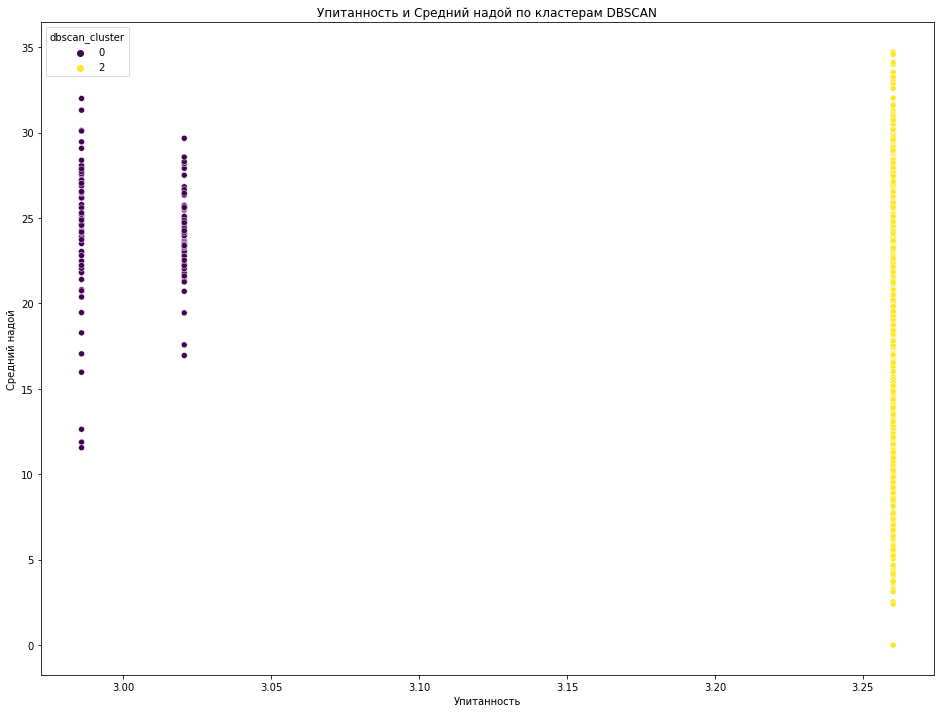

In [612]:
ax = sns.scatterplot(x='Fatness', y='MilkingAmount', hue='dbscan_cluster', data=df_cow_all.loc[(df_cow_all['dbscan_cluster'] == 2) | (df_cow_all['dbscan_cluster'] == 0)], palette='viridis')
ax.set_title('Упитанность и Средний надой по кластерам DBSCAN')
ax.set_ylabel('Средний надой');
ax.set_xlabel('Упитанность');

In [613]:
df_cow_all_dbcluster_neg_1 = df_cow_all.loc[(df_cow_all['dbscan_cluster'] == -1)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [614]:
df_cow_all_dbcluster_neg_1.describe()

MilkingAmount  MilkingTime      Fatness  CowDiagnosis  LamenessSchema  \
count    2860.000000  2860.000000  2860.000000   2860.000000     2860.000000   
mean       22.053698   625.865154     3.146976      7.113636        4.907692   
std         7.123313   233.386645     0.290010      6.608263        8.678987   
min         0.000000     0.000000     1.000000      0.000000        0.000000   
25%        19.391053   558.223245     3.000000      2.000000        0.000000   
50%        22.393677   621.621274     3.125000      5.000000        1.000000   
75%        24.692122   668.393107     3.312500     10.000000        6.000000   
max       127.435500  3592.700000     5.000000     61.000000       70.000000   

         MawSchema   TherSchema   TimpScheme  TraumaSchema  VaccinPrep  \
count  2860.000000  2860.000000  2860.000000   2860.000000  2860.00000   
mean      0.067483     0.474476     0.105245      0.833566     8.26014   
std       0.286074     0.897538     0.446243      2.004610     3.83484   
min       0.000000     0.000000     0.000000      0.000000     0.00000   
25%       0.000000     0.000000     0.000000      0.000000     6.00000   
50%       0.000000     0.000000     0.000000      0.000000     8.00000   
75%       0.000000     1.000000     0.000000      1.000000    11.00000   
max       4.000000     8.000000     9.000000     31.000000    23.00000   

        TempSchema  DeathReason  
count  2860.000000  2860.000000  
mean      0.286364     0.171678  
std       0.696885     0.381775  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       7.000000     2.000000

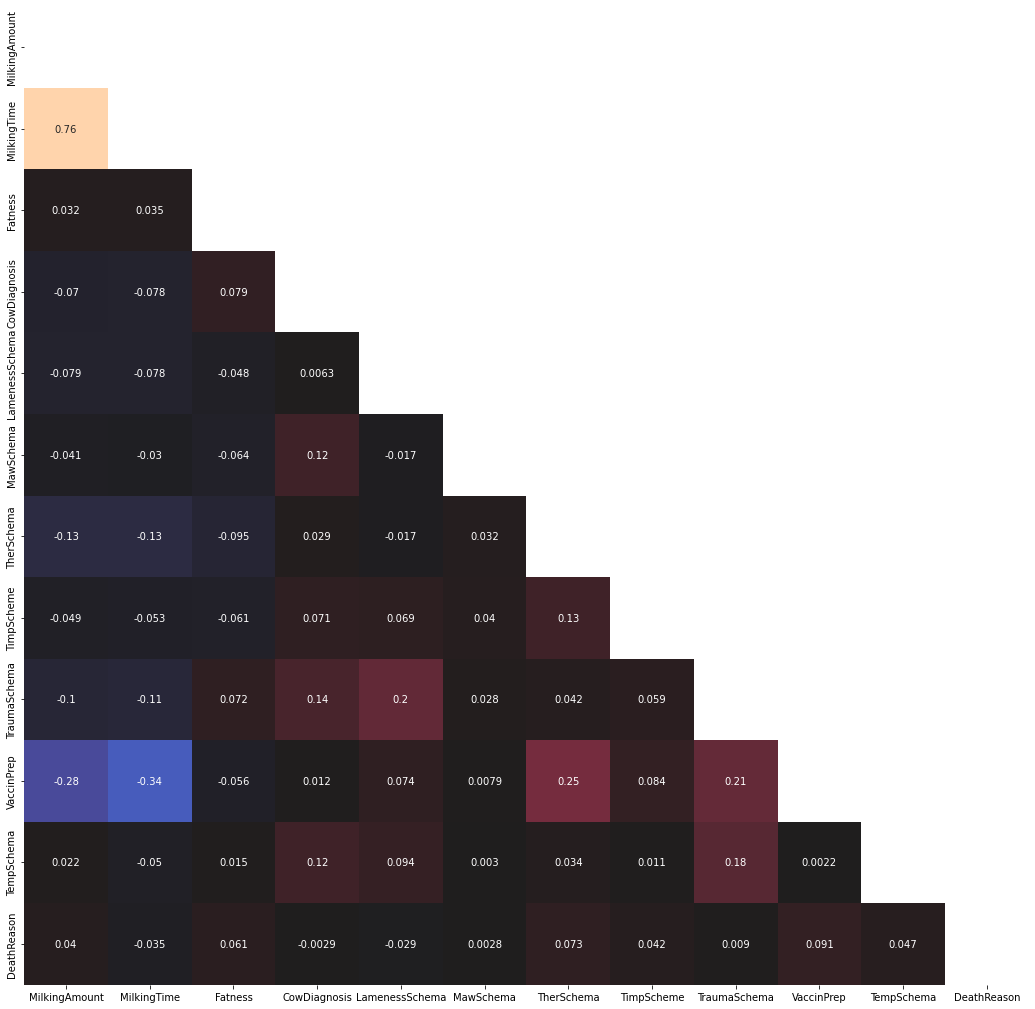

In [615]:
plt.figure(figsize=(18,18))

corr_matrix = df_cow_all_dbcluster_neg_1.corr()   #.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster','kmeans_cluster'])
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

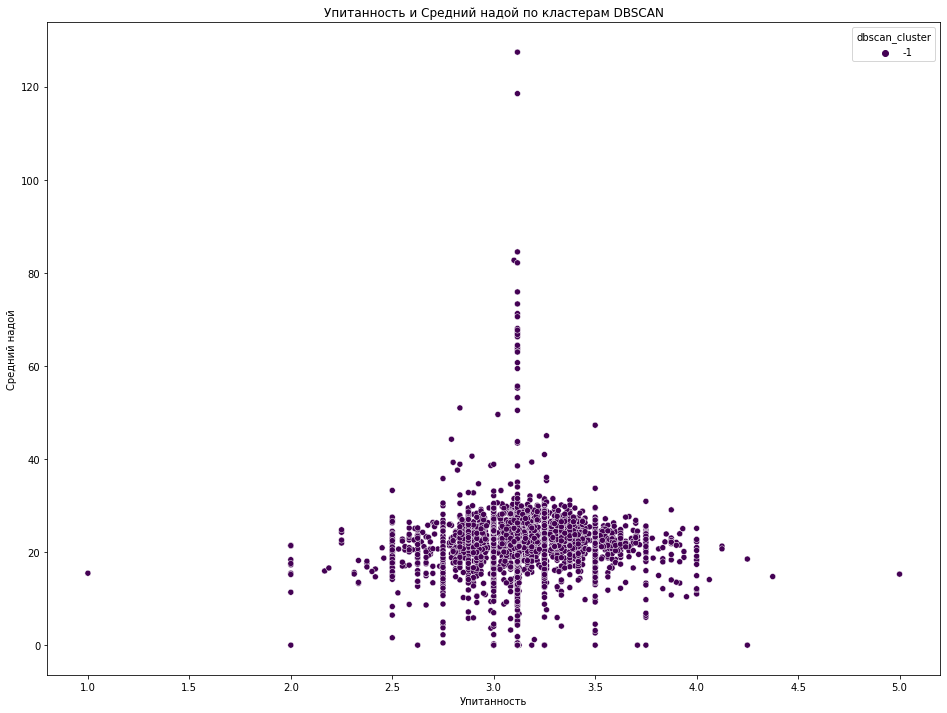

In [616]:
ax = sns.scatterplot(x='Fatness', y='MilkingAmount', hue='dbscan_cluster', data=df_cow_all.loc[(df_cow_all['dbscan_cluster'] == -1)], palette='viridis')
ax.set_title('Упитанность и Средний надой по кластерам DBSCAN')
ax.set_ylabel('Средний надой');
ax.set_xlabel('Упитанность');

In [617]:
df_cow_all_dbcluster_0 = df_cow_all.loc[(df_cow_all['dbscan_cluster'] == 0)].drop(columns=['kmeans_cluster','dbscan_cluster','optics_cluster','svm_cluster','CowID'], axis=1)

In [618]:
df_cow_all_dbcluster_0.describe()

MilkingAmount  MilkingTime     Fatness  CowDiagnosis  LamenessSchema  \
count     156.000000   156.000000  156.000000         156.0           156.0   
mean       24.214200   626.836253    3.004321           0.0             0.0   
std         3.120903    63.357729    0.017385           0.0             0.0   
min        11.553191   437.063830    2.985843           0.0             0.0   
25%        23.032326   581.146764    2.985843           0.0             0.0   
50%        24.270206   629.270370    3.020573           0.0             0.0   
75%        25.720990   677.900736    3.020573           0.0             0.0   
max        31.996111   797.155642    3.020573           0.0             0.0   

       MawSchema  TherSchema  TimpScheme  TraumaSchema  VaccinPrep  \
count      156.0       156.0       156.0         156.0       156.0   
mean         0.0         0.0         0.0           0.0         0.0   
std          0.0         0.0         0.0           0.0         0.0   
min          0.0         0.0         0.0           0.0         0.0   
25%          0.0         0.0         0.0           0.0         0.0   
50%          0.0         0.0         0.0           0.0         0.0   
75%          0.0         0.0         0.0           0.0         0.0   
max          0.0         0.0         0.0           0.0         0.0   

       TempSchema  DeathReason  
count       156.0        156.0  
mean          0.0          0.0  
std           0.0          0.0  
min           0.0          0.0  
25%           0.0          0.0  
50%           0.0          0.0  
75%           0.0          0.0  
max           0.0          0.0

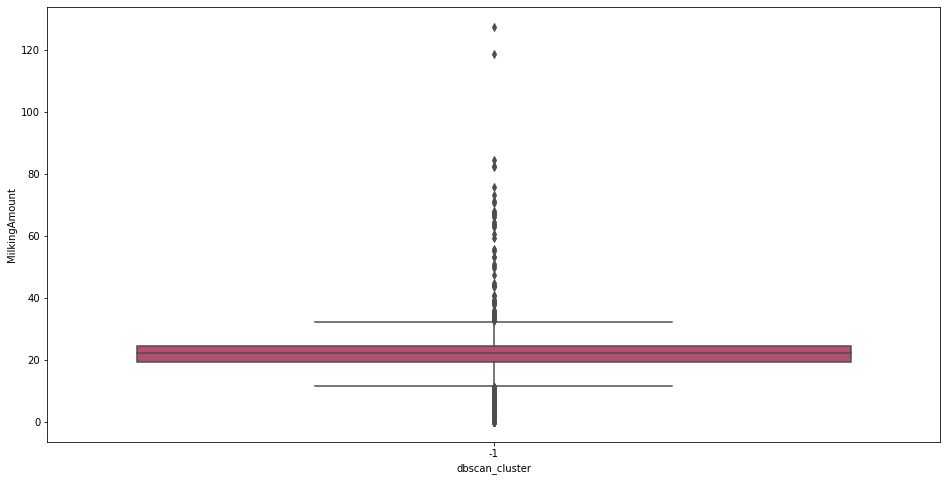

In [619]:
plt.figure(figsize=(16,8))
sns.boxplot(y='MilkingAmount',x='dbscan_cluster', data=df_cow_all.loc[(df_cow_all['dbscan_cluster'] == -1)], palette='flare')
plt.show()

In [620]:
# df_cow_all.loc[(df_cow_all['dbscan_cluster'] == 2) & (df_cow_all['MilkingAmount'] < 22.0)].to_csv('DBSCAN_cluster_2.csv')  

In [621]:
# df_cow_all.loc[(df_cow_all['dbscan_cluster'] == 2) & (df_cow_all['MilkingAmount'] < 22.0)].shape

In [622]:
# df_cow_all.loc[(df_cow_all['dbscan_cluster'] == -1) & (df_cow_all['MilkingAmount'] > 35.0)].shape

In [623]:
# df_cow_all.loc[(df_cow_all['dbscan_cluster'] == 0) & (df_cow_all['MilkingAmount'] < 24.0)].to_csv('DBSCAN_cluster_0.csv') 

In [624]:
# df_cow_all.loc[(df_cow_all['dbscan_cluster'] == -1) & (df_cow_all['MilkingAmount'] > 35.0)].to_csv('DBSCAN_cluster_-1.csv') 

In [625]:
# df_cow_all.loc[(df_cow_all['optics_cluster'] == 2)].to_csv('OPTICS_cluster_2.csv')

In [626]:
# df_cow_all.loc[(df_cow_all['optics_cluster'] == 3)].to_csv('OPTICS_cluster_3.csv')

In [627]:
# df_cow_all.loc[(df_cow_all['optics_cluster'] == 4) & (df_cow_all['MilkingAmount'] < 21.0)].to_csv('OPTICS_cluster_4.csv')

In [628]:
# df_cow_all.loc[(df_cow_all['optics_cluster'] == 4) & (df_cow_all['MilkingAmount'] < 21.0)].shape

In [629]:
# plt.figure(figsize=(18,18))

# corr_matrix = df_cow_all_present.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster']).corr()   #.drop(columns=['dbscan_cluster','optics_cluster','svm_cluster','kmeans_cluster'])
# lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

# sns.heatmap(lower, annot=True, cbar=False, center=0);

In [630]:
# cluster_list = ['kmeans_cluster','dbscan_cluster','svm_cluster','optics_cluster']

In [631]:
# for cluster_name in cluster_list:
#     for feature_name in feature_list_ext:
#         plt.figure(figsize=(16,8))
#         sns.boxplot(y=feature_name,x=cluster_name, data=df_cow_all, palette='flare')
#         plt.show()